###### This is a duplicate of `World_Happiness.ipynb` that uses an alternate hyperparameter tuning library, Optuna.

## 📊 Introduction
The goal of this project is to analyze happiness scores across different countries over the years and identify which factors most strongly influence national well-being. By understanding which elements contribute positively or negatively to happiness—such as economic indicators, health, governance, and social support—we can help inform future policies and strategic planning aimed at improving quality of life globally.

## Why We Chose This Dataset

We chose the **World Happiness Report dataset** because:

- ✅ **Recent data** – it includes the latest available happiness scores up to **2024**, making the analysis timely and relevant.
- 🌍 **Global coverage** – the dataset contains data from **~150+ countries**, allowing for broad cross-country comparisons.
- 📊 **Rich indicators** – in addition to the main **Life Ladder (happiness score)**, it provides key explanatory factors such as:
  - **Log GDP per capita** (economic prosperity)
  - **Social support** (community strength)
  - **Healthy life expectancy at birth** (health outcomes)
  - **Freedom to make life choices**
  - **Generosity**
  - **Perceptions of corruption**
  - **Positive and Negative affect** (emotional well-being)

Together, these indicators make the dataset ideal for **exploring global happiness trends** and **building predictive models** to understand what truly drives happiness worldwide.


In [7]:
# installing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import optuna
import xgboost
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor



In [8]:
# read data
world_happiness_df = pd.read_csv("World-happiness-report-updated_2024.csv",  encoding="latin1")

In [9]:
world_happiness_df.shape

(2363, 11)

- There are 2,363 rows and 11 columns.


In [10]:
world_happiness_df.sample(5)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
2000,Sweden,2019,7.398,10.875,0.934,71.90,0.942,0.085,0.250,0.775,0.202
817,Guyana,2007,5.993,9.089,0.849,56.24,0.694,0.082,0.836,0.761,0.296
1698,Poland,2021,5.978,10.461,0.936,69.05,0.732,0.122,0.744,0.700,0.277
1752,Russia,2019,5.441,10.213,0.910,64.20,0.715,-0.122,0.848,0.632,0.200
450,Congo (Brazzaville),2011,4.510,8.502,0.637,53.38,0.745,-0.137,0.833,0.601,0.288


Life Ladder → This is the actual happiness score (0–10).

Log GDP per capita → Economic factor, log-scaled for comparability.

Social support → Proportion of people with someone to rely on.

Healthy life expectancy at birth → Years expected in good health.

Freedom to make life choices → Satisfaction with freedom.

Generosity → Adjusted measure of charitable giving (can be negative).

Perceptions of corruption → Higher values = higher perceived corruption.

Positive affect / Negative affect → Average emotions reported.

Year → Lets you see trends over time.


In [11]:
# understanding data
world_happiness_df.head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.5,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.8,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.1,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.4,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.7,0.531,0.234,0.776,0.614,0.268


In [12]:
# Statistical summary of the data
world_happiness_df.describe()

,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
count,2363.000000,2363.000000,2335.000000,2350.000000,2300.000000,2327.000000,2282.000000,2238.000000,2339.000000,2347.000000
mean,2014.763860,5.483566,9.399671,0.809369,63.401828,0.750282,0.000098,0.743971,0.651882,0.273151
std,5.059436,1.125522,1.152069,0.121212,6.842644,0.139357,0.161388,0.184865,0.106240,0.087131
min,2005.000000,1.281000,5.527000,0.228000,6.720000,0.228000,-0.340000,0.035000,0.179000,0.083000
25%,2011.000000,4.647000,8.506500,0.744000,59.195000,0.661000,-0.112000,0.687000,0.572000,0.209000
50%,2015.000000,5.449000,9.503000,0.834500,65.100000,0.771000,-0.022000,0.798500,0.663000,0.262000
75%,2019.000000,6.323500,10.392500,0.904000,68.552500,0.862000,0.093750,0.867750,0.737000,0.326000
max,2023.000000,8.019000,11.676000,0.987000,74.600000,0.985000,0.700000,0.983000,0.884000,0.705000


In [13]:
# Understanding data types and missing values
world_happiness_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


- There are few missing data here.


In [14]:
world_happiness_df["Country name"].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo (Brazzaville)', 'Congo (Kinshasa)',
       'Costa Rica', 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Estonia', 'Eswatini', 'Ethiopia', 'Finland',
       'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana',
       'Greece', 'Guatemala', 'Guinea', 'Guyana', 'Haiti', 'Honduras',
       'Hong Kong S.A.R. of China', 'Hungary', 'Iceland', 'India',
       'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Ivory Coast', 'Jamaica', 'Japan', 

### Visualization


In [15]:
df = world_happiness_df.copy()

### Top and Bottom 10 Countries by Happiness (2024)

To get an overview of global happiness in the most recent year, we look at the **Life Ladder** scores:

- The **top 10 happiest countries** have the highest average Life Ladder scores.
- The **bottom 10 countries** show where people report the lowest perceived well-being.

These bar charts highlight the wide gap in happiness levels across the world and set the stage for exploring what factors (GDP, social support, life expectancy, etc.) might explain these differences.


C:\Users\kenklabnik\AppData\Local\Temp\ipykernel_45024\3735363238.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")


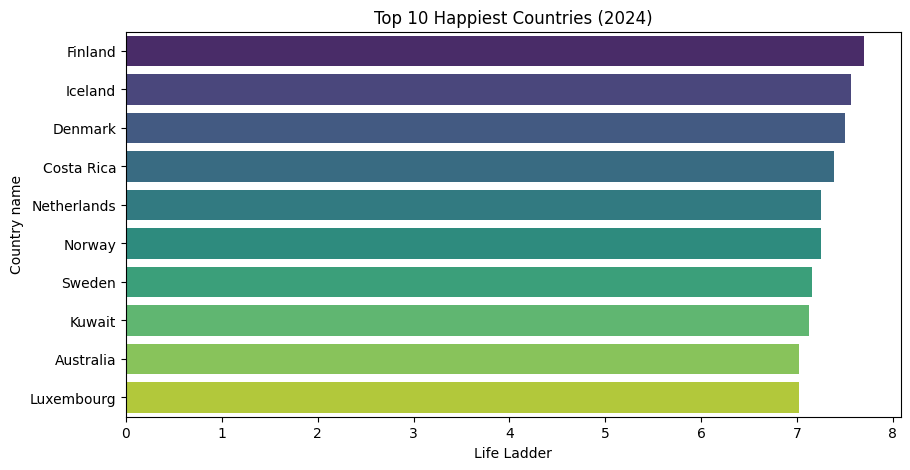

C:\Users\kenklabnik\AppData\Local\Temp\ipykernel_45024\3735363238.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")


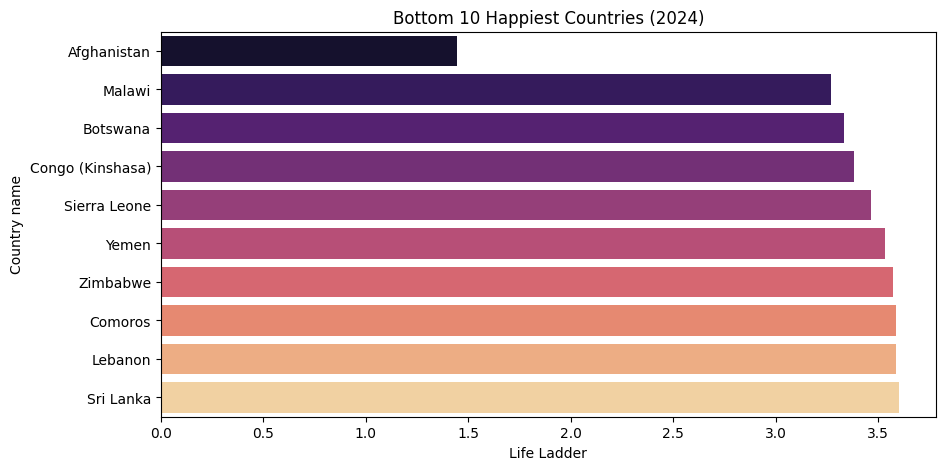

In [16]:
# Filter for latest year (2024 if available)
latest = df[df['year'] == df['year'].max()]

top10 = latest.nlargest(10, 'Life Ladder')
bottom10 = latest.nsmallest(10, 'Life Ladder')

plt.figure(figsize=(10,5))
sns.barplot(data=top10, x='Life Ladder', y='Country name', palette="viridis")
plt.title("Top 10 Happiest Countries (2024)")
plt.show()

plt.figure(figsize=(10,5))
sns.barplot(data=bottom10, x='Life Ladder', y='Country name', palette="magma")
plt.title("Bottom 10 Happiest Countries (2024)")
plt.show()

### Happiness Trends Over Time

This line plot shows how **Life Ladder (happiness score)** has changed from year to year for a selection of countries:

- **Finland** (one of the happiest countries worldwide)
- **India** (large developing country with improving but fluctuating scores)
- **United States** (a high-income country with mid-high happiness levels)
- **Afghanistan** (among the lowest happiness scores globally)

By comparing these diverse cases, we can see both **long-term stability in high-scoring countries** (e.g., Finland) and **sharp declines or volatility** in regions affected by conflict or economic challenges. This helps illustrate the global disparities in well-being over time.


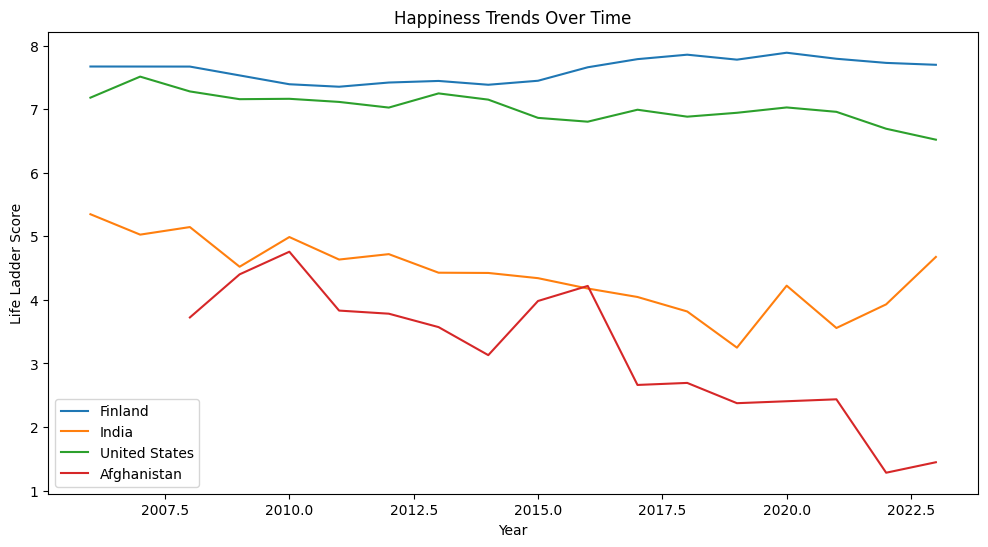

In [17]:
countries = ["Finland", "India", "United States", "Afghanistan"]
plt.figure(figsize=(12,6))
for c in countries:
    subset = df[df['Country name'] == c]
    plt.plot(subset['year'], subset['Life Ladder'], label=c)

plt.title("Happiness Trends Over Time")
plt.xlabel("Year")
plt.ylabel("Life Ladder Score")
plt.legend()
plt.show()

### Key Factors Driving Happiness

To understand what drives happiness, we compare **Life Ladder scores** with three important factors in 2024:

- **Log GDP per capita** → captures the role of income and economic prosperity
- **Social support** → reflects the strength of community and relationships
- **Healthy life expectancy at birth** → measures health and longevity

Each scatter plot includes a regression line, making it easier to see overall trends.  
We observe that countries with **higher GDP, stronger social support, and longer life expectancy** tend to report higher happiness scores.  
This provides evidence that both **economic** and **social factors** play a critical role in well-being.


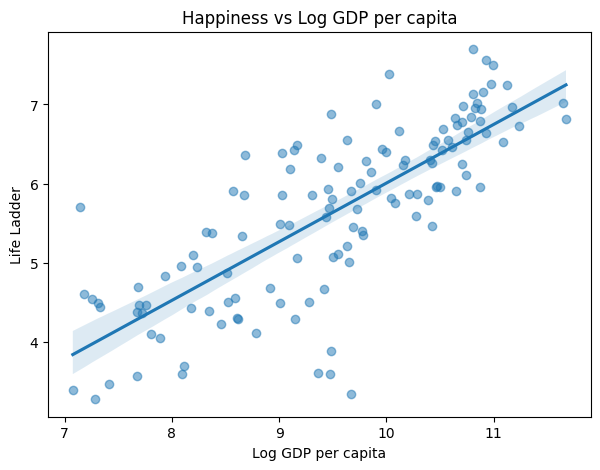

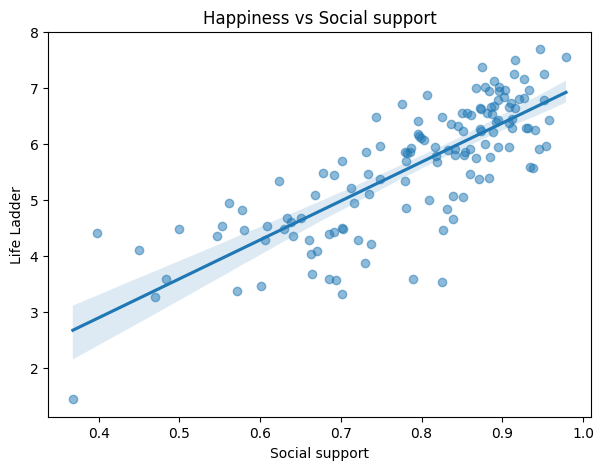

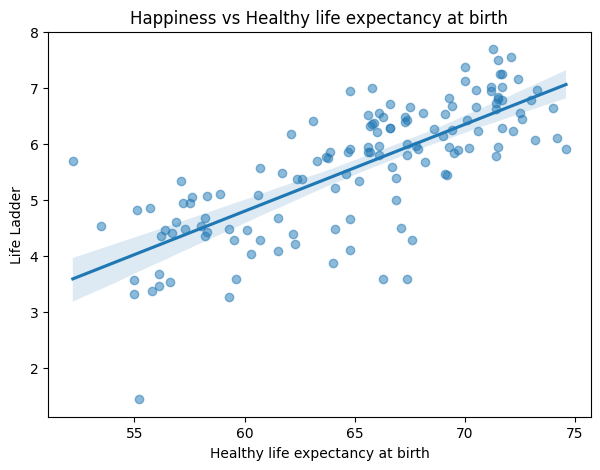

In [18]:
factors = ["Log GDP per capita", "Social support", "Healthy life expectancy at birth"]
for factor in factors:
    plt.figure(figsize=(7,5))
    sns.regplot(data=latest, x=factor, y="Life Ladder", scatter_kws={'alpha':0.5})
    plt.title(f"Happiness vs {factor}")
    plt.show()

### Correlation Between Happiness and Other Factors

This heatmap shows the correlations between **Life Ladder (happiness score)** and its key predictors:

- Strong **positive correlations**:
  - **GDP per capita**, **Social support**, **Life expectancy**, and **Freedom to make life choices** all align closely with higher happiness.
- Weak or mixed correlations:
  - **Generosity** and **Positive affect** show smaller positive links.
- **Negative correlation**:
  - **Perceptions of corruption** is strongly associated with lower happiness.
  - **Negative affect** also tends to reduce happiness.

Overall, the heatmap confirms that **economic prosperity, social ties, health, and freedom** are the most powerful drivers of happiness, while corruption and negative emotions erode well-being.


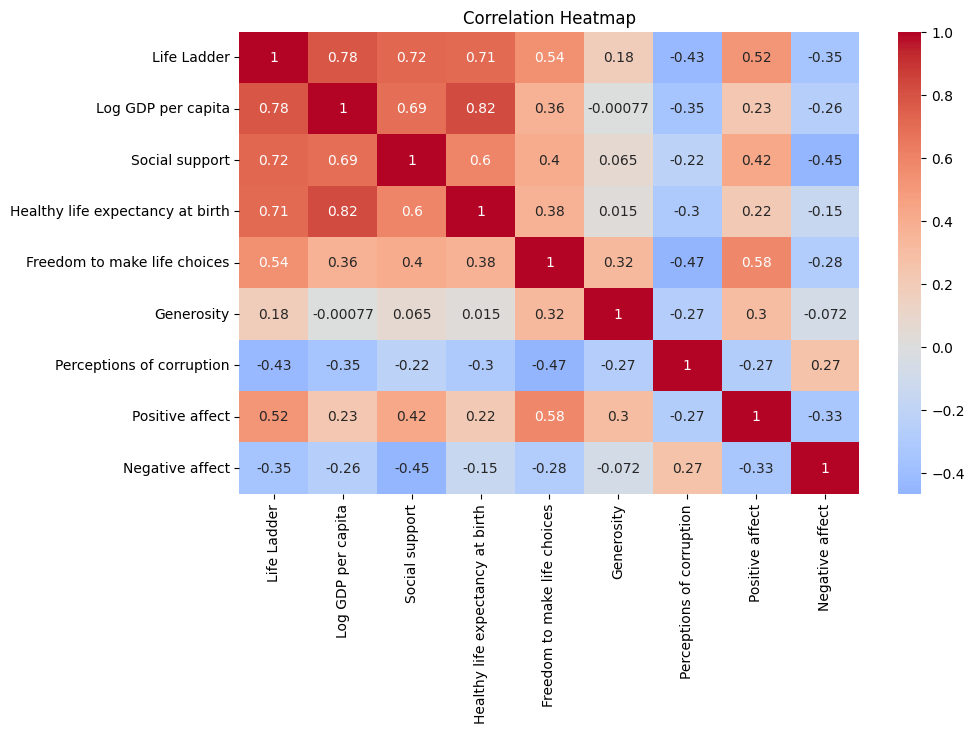

In [19]:
plt.figure(figsize=(10,6))
corr = df[["Life Ladder", "Log GDP per capita", "Social support",
           "Healthy life expectancy at birth", "Freedom to make life choices",
           "Generosity", "Perceptions of corruption",
           "Positive affect", "Negative affect"]].corr()

sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


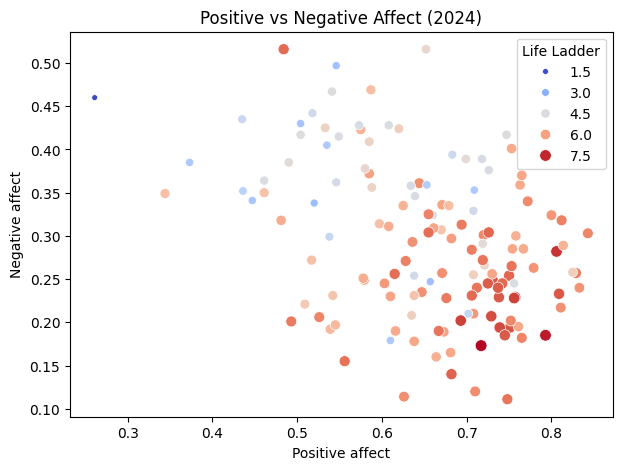

In [20]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=latest, x="Positive affect", y="Negative affect", hue="Life Ladder", size="Life Ladder", palette="coolwarm")
plt.title("Positive vs Negative Affect (2024)")
plt.show()

### Positive vs Negative Affect (2024)

This scatter plot compares countries based on **Positive affect** (frequency of positive emotions) and **Negative affect** (frequency of negative emotions) in 2024.

- The color and size of each point represent the **Life Ladder score** (overall happiness).
- Countries with **higher positive affect and lower negative affect** tend to report the highest happiness scores.
- Conversely, countries with **higher negative affect** cluster toward the lower end of the happiness scale.

This visualization highlights the strong emotional dimension of well-being, showing that happiness is not only about income or health but also about the balance of day-to-day emotions.


In [21]:
fig = px.choropleth(
    df,
    locations="Country name",               # column with country names
    locationmode="country names",      # match locations with country names
    color="Life Ladder",           # column to color by
    hover_name="Country name",              # tooltip
    color_continuous_scale="Viridis",  # color theme
    title="World Happiness Scores (2024)"
)

fig.show()

# Data Preprocessing and Modeling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2363 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2363 non-null   object 
 1   year                              2363 non-null   int64  
 2   Life Ladder                       2363 non-null   float64
 3   Log GDP per capita                2335 non-null   float64
 4   Social support                    2350 non-null   float64
 5   Healthy life expectancy at birth  2300 non-null   float64
 6   Freedom to make life choices      2327 non-null   float64
 7   Generosity                        2282 non-null   float64
 8   Perceptions of corruption         2238 non-null   float64
 9   Positive affect                   2339 non-null   float64
 10  Negative affect                   2347 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 203.2+ KB


In [ ]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 2097 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2097 non-null   object 
 1   year                              2097 non-null   int64  
 2   Life Ladder                       2097 non-null   float64
 3   Log GDP per capita                2097 non-null   float64
 4   Social support                    2097 non-null   float64
 5   Healthy life expectancy at birth  2097 non-null   float64
 6   Freedom to make life choices      2097 non-null   float64
 7   Generosity                        2097 non-null   float64
 8   Perceptions of corruption         2097 non-null   float64
 9   Positive affect                   2097 non-null   float64
 10  Negative affect                   2097 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 196.6+ KB


We have a pretty small amount of data: if we just dropped any line with a NaN value, we'd have fewer than 2100 lines! Even the full dataset only has 2363.

In [ ]:
df.head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Demonstrating the structure of the problem. No NaNs in country name, thankfully. Presumably NaN appears where data is unavailable.

Likely the best we can do is infer those values from previous results.

In [ ]:
df[df['Log GDP per capita'].isna() == True].head()

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
13,Afghanistan,2022,1.281,NaN,0.228,54.875,0.368,NaN,0.733,0.206,0.576
14,Afghanistan,2023,1.446,NaN,0.368,55.200,0.228,NaN,0.738,0.261,0.460
507,Cuba,2006,5.418,NaN,0.970,68.000,0.281,NaN,NaN,0.596,0.277
523,Cyprus,2023,6.071,NaN,0.803,73.200,0.730,NaN,0.840,0.682,0.297
1100,Kosovo,2007,5.104,NaN,0.848,NaN,0.381,NaN,0.894,0.614,0.237


In [ ]:
df['year'].value_counts().sort_index(ascending=True)

year
2005     27
2006     89
2007    102
2008    110
2009    114
2010    124
2011    146
2012    141
2013    136
2014    144
2015    142
2016    141
2017    147
2018    141
2019    143
2020    116
2021    122
2022    140
2023    138
Name: count, dtype: int64

Simply forward- or backward-propagating or interpolating is going to be questionable. Not all information is available in every country in every year, so doing that naively may result in problems (e.g. Afghanistan's last year's GDP is NaN; backpropagating would fill it with info from Albania, which would be wrong). 

In [ ]:
numeric_columns = df.select_dtypes(include='number').columns
df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1).head(16)

,Country name,year,Life Ladder,Log GDP per capita,Social support,Healthy life expectancy at birth,Freedom to make life choices,Generosity,Perceptions of corruption,Positive affect,Negative affect
0,Afghanistan,2008,3.724,7.350,0.451,50.500,0.718,0.164,0.882,0.414,0.258
1,Afghanistan,2009,4.402,7.509,0.552,50.800,0.679,0.187,0.850,0.481,0.237
2,Afghanistan,2010,4.758,7.614,0.539,51.100,0.600,0.118,0.707,0.517,0.275
3,Afghanistan,2011,3.832,7.581,0.521,51.400,0.496,0.160,0.731,0.480,0.267
4,Afghanistan,2012,3.783,7.661,0.521,51.700,0.531,0.234,0.776,0.614,0.268
5,Afghanistan,2013,3.572,7.680,0.484,52.000,0.578,0.059,0.823,0.547,0.273
6,Afghanistan,2014,3.131,7.671,0.526,52.300,0.509,0.102,0.871,0.492,0.375
7,Afghanistan,2015,3.983,7.654,0.529,52.600,0.389,0.078,0.881,0.491,0.339
8,Afghanistan,2016,4.220,7.650,0.559,52.925,0.523,0.040,0.793,0.501,0.348
9,Afghanistan,2017,2.662,7.648,0.491,53.250,0.427,-0.123,0.954,0.435,0.371


Notice that Afghanistan's `Log GDP per capita` in 2022 and 2023 has been interpolated from 2021 without referencing the following row from Albania (so identical to forward propagation in this case). This basically gives our best estimate of what the missing data would be--it's not perfect, but we gain more from being able to preserve everything else in those columns.

In [ ]:
data = df.groupby('Country name')[numeric_columns].apply(lambda group: group.infer_objects(copy=False).interpolate()).reset_index().drop('level_1', axis=1)

In [ ]:
data.isna().sum()

Country name                         0
year                                 0
Life Ladder                          0
Log GDP per capita                  10
Social support                       4
Healthy life expectancy at birth    50
Freedom to make life choices         8
Generosity                          43
Perceptions of corruption           45
Positive affect                      8
Negative affect                      6
dtype: int64

There are still a few nulls that didn't get caught, but way fewer, so I'm fine dropping from here.

In [ ]:
data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2229 entries, 0 to 2362
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Country name                      2229 non-null   object 
 1   year                              2229 non-null   int64  
 2   Life Ladder                       2229 non-null   float64
 3   Log GDP per capita                2229 non-null   float64
 4   Social support                    2229 non-null   float64
 5   Healthy life expectancy at birth  2229 non-null   float64
 6   Freedom to make life choices      2229 non-null   float64
 7   Generosity                        2229 non-null   float64
 8   Perceptions of corruption         2229 non-null   float64
 9   Positive affect                   2229 non-null   float64
 10  Negative affect                   2229 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 209.0+ KB


The categorical `Country name` needs to be label encoded so that it can be handled numerically.

In [ ]:
# data['country_label'] = data['Country name'].sort_values(ascending=True).astype('category').cat.codes
# data.sample(10)

data.drop('Country name', axis=1, inplace=True)

Since we're using time series data, we'll have the training set be years through 2019, and the test set be 2020 and onward (so roughly 1700 and 500 entries respectively, about 3.4 to 1 training to test ratio).

In [ ]:
split_year = 2019
training = data[data['year'] <= split_year]
test = data[data['year'] > split_year]

training.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1725 entries, 0 to 2358
Data columns (total 10 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   year                              1725 non-null   int64  
 1   Life Ladder                       1725 non-null   float64
 2   Log GDP per capita                1725 non-null   float64
 3   Social support                    1725 non-null   float64
 4   Healthy life expectancy at birth  1725 non-null   float64
 5   Freedom to make life choices      1725 non-null   float64
 6   Generosity                        1725 non-null   float64
 7   Perceptions of corruption         1725 non-null   float64
 8   Positive affect                   1725 non-null   float64
 9   Negative affect                   1725 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 148.2 KB


In [ ]:

features_train = training.drop(['Life Ladder'], axis=1)
features_test = test.drop(['Life Ladder'], axis=1)
target_train = training['Life Ladder']
target_test = test['Life Ladder']


Lastly, we need to ensure that our features are scaled; log GDP and life expectancy are both relatively large numbers compared to the other features and may have disproportionate impact on the model. We fit a StandardScaler on the just training features, because otherwise the scaler acts as a "hint" to the model during training (i.e. data leaks out of the test set), then we use it to transform both the features and target.

# Optuna and Modeling

Optuna is a library that specializes in tuning hyperparameters for machine learning models. This prevents us from having to code our own search or use something like scikit-learn's built-in functions, which are a little slow. For the purposes of this, we'll use XGBoost's random forest model.

Here's the sanity-check model, which is just sklearn's linear regression:

In [ ]:
lr = LinearRegression()
lr.fit(features_train, target_train)
lr_pred = lr.predict(features_test)
lr_mae = mean_absolute_error(target_test, lr_pred)
lr_mae

0.3947212943765264

A good model should be able to beat this mean absolute error, no problem.

To use Optuna, we have to define functions called `objective` and `define_model`:

In [ ]:
## Optuna with XGboostRF Regressor model 
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model = xgboost.XGBRFRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model

def objective(trial):
    model = define_model(trial)
    model.fit(features_train, target_train)
    target_pred = model.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-02 12:04:53,474] A new study created in memory with name: no-name-5c767209-7edb-4eaa-836a-a6a0b482da60
[I 2025-10-02 12:04:53,621] Trial 0 finished with value: 0.3764296010865106 and parameters: {'n_estimators': 160, 'max_depth': 6}. Best is trial 0 with value: 0.3764296010865106.
[I 2025-10-02 12:04:53,699] Trial 1 finished with value: 0.38801400375366213 and parameters: {'n_estimators': 150, 'max_depth': 5}. Best is trial 0 with value: 0.3764296010865106.
[I 2025-10-02 12:04:53,773] Trial 2 finished with value: 0.3564229223879557 and parameters: {'n_estimators': 40, 'max_depth': 8}. Best is trial 2 with value: 0.3564229223879557.
[I 2025-10-02 12:04:53,793] Trial 3 finished with value: 0.44464433674963694 and parameters: {'n_estimators': 50, 'max_depth': 3}. Best is trial 2 with value: 0.3564229223879557.
[I 2025-10-02 12:04:53,872] Trial 4 finished with value: 0.3488451427315909 and parameters: {'n_estimators': 30, 'max_depth': 9}. Best is trial 4 with value: 0.3488451427

In [ ]:
print('Best RF parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances



Best RF parameters:  {'n_estimators': 90, 'max_depth': 15}
At trial:  12
Mean absolute error:  0.3299729511018784

Hyperparameter importances:


{'max_depth': 0.9641187501673174, 'n_estimators': 0.03588124983268264}

So, for this data, we know the following about XGBoost's random forest: the best hyperparameters we could find were 100 trees with a max depth of 14; we were able to achieve a MAE of 0.319; and the max_depth parameter had a way bigger effect on the outcome of the forest than the n_estimators parameter did.

In [ ]:
## Optuna with LGBM Regressor
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 2, 15, step=1)
    model1 = LGBMRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model1

def objective(trial):
    model1 = define_model(trial)
    model1.fit(features_train, target_train)
    target_pred = model1.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-02 12:05:16,892] A new study created in memory with name: no-name-6347cd39-08c2-408d-862c-77b33f0b7fcf
c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\Sohin\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Sohin\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:16,982] Trial 1 finished with value: 0.4943579390280066 and parameters: {'n_estimators': 10, 'max_depth': 7}. Best is trial 0 with value: 0.33001035193815326.
[I 2025-10-02 12:05:17,055] Trial 2 finished with value: 0.32829454193766827 and parameters: {'n_estimators': 180, 'max_depth': 6}. Best is trial 2 with value: 0.32829454193766827.
[I 2025-10-02 12:05:17,092] Trial 3 finished with value: 0.33071538289780245 and parameters: {'n_estimators': 50, 'max_depth': 14}. Best is trial 2 with value: 0.32829454193766827.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2025-10-02 12:05:17,143] Trial 4 finished with value: 0.33496969132128823 and parameters: {'n_estimators': 180, 'max_depth': 4}. Best is trial 2 with value: 0.32829454193766827.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:17,238] Trial 5 finished with value: 0.3225531819039058 and parameters: {'n_estimators': 150, 'max_depth': 10}. Best is trial 5 with value: 0.3225531819039058.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-02 12:05:17,310] Trial 6 finished with value: 0.32102096316626655 and parameters: {'n_estimators': 110, 'max_depth': 11}. Best is trial 6 with value: 0.32102096316626655.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:17,370] Trial 7 finished with value: 0.3272622266815085 and parameters: {'n_estimators': 90, 'max_depth': 12}. Best is trial 6 with value: 0.32102096316626655.
[I 2025-10-02 12:05:17,387] Trial 8 pruned. 
[I 2025-10-02 12:05:17,401] Trial 9 pruned. 
[I 2025-10-02 12:05:17,488] Trial 10 finished with value: 0.32322901884720373 and parameters: {'n_estimators': 130, 'max_depth': 15}. Best is trial 6 with value: 0.32102096316626655.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:17,575] Trial 11 finished with value: 0.32332036115695667 and parameters: {'n_estimators': 140, 'max_depth': 10}. Best is trial 6 with value: 0.32102096316626655.
[I 2025-10-02 12:05:17,664] Trial 12 finished with value: 0.32332036115695667 and parameters: {'n_estimators': 140, 'max_depth': 10}. Best is trial 6 with value: 0.32102096316626655.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:17,732] Trial 13 finished with value: 0.32203951185258234 and parameters: {'n_estimators': 110, 'max_depth': 9}. Best is trial 6 with value: 0.32102096316626655.
[I 2025-10-02 12:05:17,782] Trial 14 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:17,810] Trial 15 pruned. 
[I 2025-10-02 12:05:17,887] Trial 16 finished with value: 0.3239519070543261 and parameters: {'n_estimators': 110, 'max_depth': 12}. Best is trial 6 with value: 0.32102096316626655.
[I 2025-10-02 12:05:17,938] Trial 17 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:18,061] Trial 18 finished with value: 0.32122735726894297 and parameters: {'n_estimators': 200, 'max_depth': 13}. Best is trial 6 with value: 0.32102096316626655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-02 12:05:18,188] Trial 19 finished with value: 0.32122735726894297 and parameters: {'n_estimators': 200, 'max_depth': 13}. Best is trial 6 with value: 0.32102096316626655.
[I 2025-10-02 12:05:18,304] Trial 20 finished with value: 0.32149587981472755 and parameters: {'n_estimators': 170, 'max_depth': 15}. Best is trial 6 with value: 0.32102096316626655.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:18,447] Trial 21 finished with value: 0.32122735726894297 and parameters: {'n_estimators': 200, 'max_depth': 13}. Best is trial 6 with value: 0.32102096316626655.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGB

[I 2025-10-02 12:05:18,569] Trial 22 finished with value: 0.32122735726894297 and parameters: {'n_estimators': 200, 'max_depth': 13}. Best is trial 6 with value: 0.32102096316626655.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:18,669] Trial 23 finished with value: 0.3190327206564172 and parameters: {'n_estimators': 160, 'max_depth': 11}. Best is trial 23 with value: 0.3190327206564172.
[I 2025-10-02 12:05:18,769] Trial 24 finished with value: 0.3190327206564172 and parameters: {'n_estimators': 160, 'max_depth': 11}. Best is trial 23 with value: 0.3190327206564172.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-02 12:05:18,878] Trial 25 finished with value: 0.3190327206564172 and parameters: {'n_estimators': 160, 'max_depth': 11}. Best is trial 23 with value: 0.3190327206564172.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 

[I 2025-10-02 12:05:18,980] Trial 26 finished with value: 0.3190327206564172 and parameters: {'n_estimators': 160, 'max_depth': 11}. Best is trial 23 with value: 0.3190327206564172.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:19,065] Trial 27 finished with value: 0.320514582380727 and parameters: {'n_estimators': 130, 'max_depth': 11}. Best is trial 23 with value: 0.3190327206564172.
[I 2025-10-02 12:05:19,175] Trial 28 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000237 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:19,278] Trial 29 pruned. 
[I 2025-10-02 12:05:19,345] Trial 30 pruned. 


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:19,445] Trial 31 finished with value: 0.3190327206564172 and parameters: {'n_estimators': 160, 'max_depth': 11}. Best is trial 23 with value: 0.3190327206564172.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-02 12:05:19,556] Trial 32 finished with value: 0.3196962655875325 and parameters: {'n_estimators': 180, 'max_depth': 11}. Best is trial 23 with value: 0.3190327206564172.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-02 12:05:19,643] Trial 33 pruned. 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-02 12:05:19,766] Trial 34 finished with value: 0.31678161894996637 and parameters: {'n_estimators': 180, 'max_depth': 14}. Best is trial 34 with value: 0.31678161894996637.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-10-02 12:05:19,891] Trial 35 finished with value: 0.31678161894996637 and parameters: {'n_estimators': 180, 'max_depth': 14}. Best is trial 34 with value: 0.31678161894996637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:20,010] Trial 36 finished with value: 0.31678161894996637 and parameters: {'n_estimators': 180, 'max_depth': 14}. Best is trial 34 with value: 0.31678161894996637.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:20,123] Trial 37 finished with value: 0.31678161894996637 and parameters: {'n_estimators': 180, 'max_depth': 14}. Best is trial 34 with value: 0.31678161894996637.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:20,249] Trial 38 finished with value: 0.3165643460549437 and parameters: {'n_estimators': 190, 'max_depth': 14}. Best is trial 38 with value: 0.3165643460549437.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

[I 2025-10-02 12:05:20,374] Trial 39 finished with value: 0.3165643460549437 and parameters: {'n_estimators': 190, 'max_depth': 14}. Best is trial 38 with value: 0.3165643460549437.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
print('Best LGBM parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances

Best LGBM parameters:  {'n_estimators': 190, 'max_depth': 14}
At trial:  38
Mean absolute error:  0.3165643460549437

Hyperparameter importances:


{'n_estimators': 0.7564021544640835, 'max_depth': 0.24359784553591635}

So, for this data, we know the following about Light GBM: the best hyperparameters we could find with 200 estimators and max depth of 14; we were able to achieve a MAE of 0.316; and the  n_estimators parameter had a way bigger effect on the outcome  than the max_depth parameter did.

In [ ]:
## Optuna with Catboost Regressor
def define_model(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200, step=10) #parameter name, lowest value, highest value, step size respectively
    max_depth = trial.suggest_int("max_depth", 1, 15, step=1) 
    model2= CatBoostRegressor(
        n_estimators = n_estimators,
        max_depth = max_depth,
        random_state = 101010
    )
    return model2

def objective(trial):
    model2 = define_model(trial)
    model2.fit(features_train, target_train)
    target_pred = model2.predict(features_test)
    score = mean_absolute_error(target_test, target_pred)
    trial.report(score, step=1)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return score


study = optuna.create_study()
study.optimize(objective, n_trials=40)

[I 2025-10-02 12:05:20,541] A new study created in memory with name: no-name-90a46b4a-0a95-4a62-adae-136b126e3153


Learning rate set to 0.234399
0:	learn: 0.9424385	total: 134ms	remaining: 17.3s
1:	learn: 0.8069292	total: 136ms	remaining: 8.67s
2:	learn: 0.7054320	total: 137ms	remaining: 5.79s
3:	learn: 0.6345353	total: 138ms	remaining: 4.34s
4:	learn: 0.5821569	total: 139ms	remaining: 3.49s
5:	learn: 0.5426309	total: 141ms	remaining: 2.91s
6:	learn: 0.5142322	total: 142ms	remaining: 2.49s
7:	learn: 0.4951288	total: 143ms	remaining: 2.18s
8:	learn: 0.4810015	total: 144ms	remaining: 1.94s
9:	learn: 0.4699240	total: 145ms	remaining: 1.74s
10:	learn: 0.4633586	total: 146ms	remaining: 1.58s
11:	learn: 0.4533303	total: 148ms	remaining: 1.46s
12:	learn: 0.4486210	total: 149ms	remaining: 1.34s
13:	learn: 0.4437457	total: 150ms	remaining: 1.25s
14:	learn: 0.4366362	total: 152ms	remaining: 1.16s
15:	learn: 0.4328399	total: 153ms	remaining: 1.09s
16:	learn: 0.4273486	total: 154ms	remaining: 1.02s
17:	learn: 0.4234360	total: 155ms	remaining: 964ms
18:	learn: 0.4204311	total: 156ms	remaining: 913ms
19:	learn: 

[I 2025-10-02 12:05:20,907] Trial 0 finished with value: 0.34447353823766236 and parameters: {'n_estimators': 130, 'max_depth': 6}. Best is trial 0 with value: 0.34447353823766236.


47:	learn: 0.3399983	total: 192ms	remaining: 329ms
48:	learn: 0.3375261	total: 194ms	remaining: 321ms
49:	learn: 0.3361590	total: 196ms	remaining: 313ms
50:	learn: 0.3331568	total: 197ms	remaining: 305ms
51:	learn: 0.3310591	total: 198ms	remaining: 298ms
52:	learn: 0.3291301	total: 200ms	remaining: 290ms
53:	learn: 0.3266808	total: 201ms	remaining: 283ms
54:	learn: 0.3253215	total: 202ms	remaining: 276ms
55:	learn: 0.3226440	total: 203ms	remaining: 269ms
56:	learn: 0.3210016	total: 204ms	remaining: 262ms
57:	learn: 0.3201014	total: 206ms	remaining: 255ms
58:	learn: 0.3174695	total: 207ms	remaining: 249ms
59:	learn: 0.3141162	total: 208ms	remaining: 243ms
60:	learn: 0.3119145	total: 209ms	remaining: 237ms
61:	learn: 0.3086449	total: 211ms	remaining: 231ms
62:	learn: 0.3055814	total: 212ms	remaining: 225ms
63:	learn: 0.3040496	total: 213ms	remaining: 219ms
64:	learn: 0.3019274	total: 214ms	remaining: 214ms
65:	learn: 0.3000152	total: 215ms	remaining: 208ms
66:	learn: 0.2969340	total: 216

[I 2025-10-02 12:06:05,433] Trial 1 finished with value: 0.35370063554862297 and parameters: {'n_estimators': 170, 'max_depth': 15}. Best is trial 0 with value: 0.34447353823766236.
[I 2025-10-02 12:06:05,486] Trial 2 finished with value: 0.3982857516663225 and parameters: {'n_estimators': 10, 'max_depth': 3}. Best is trial 0 with value: 0.34447353823766236.
[I 2025-10-02 12:06:05,551] Trial 3 finished with value: 0.3627420157411618 and parameters: {'n_estimators': 30, 'max_depth': 4}. Best is trial 0 with value: 0.34447353823766236.


Learning rate set to 0.5
0:	learn: 0.7843319	total: 856us	remaining: 7.71ms
1:	learn: 0.6169377	total: 1.4ms	remaining: 5.62ms
2:	learn: 0.5618536	total: 1.92ms	remaining: 4.47ms
3:	learn: 0.5346760	total: 2.4ms	remaining: 3.6ms
4:	learn: 0.5167521	total: 2.89ms	remaining: 2.89ms
5:	learn: 0.5054276	total: 3.41ms	remaining: 2.27ms
6:	learn: 0.4975833	total: 4.1ms	remaining: 1.76ms
7:	learn: 0.4933066	total: 4.61ms	remaining: 1.15ms
8:	learn: 0.4874138	total: 5.13ms	remaining: 570us
9:	learn: 0.4823040	total: 5.62ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.7705664	total: 1.34ms	remaining: 38.8ms
1:	learn: 0.6258227	total: 2.28ms	remaining: 31.9ms
2:	learn: 0.5439746	total: 2.97ms	remaining: 26.7ms
3:	learn: 0.5109764	total: 3.63ms	remaining: 23.6ms
4:	learn: 0.4931098	total: 4.34ms	remaining: 21.7ms
5:	learn: 0.4847456	total: 4.98ms	remaining: 19.9ms
6:	learn: 0.4782577	total: 5.68ms	remaining: 18.7ms
7:	learn: 0.4744883	total: 6.28ms	remaining: 17.3ms
8:	learn: 0.4678890	tot

[I 2025-10-02 12:06:11,898] Trial 4 finished with value: 0.3556541438822616 and parameters: {'n_estimators': 90, 'max_depth': 13}. Best is trial 0 with value: 0.34447353823766236.


89:	learn: 0.0435126	total: 6.25s	remaining: 0us
Learning rate set to 0.316077
0:	learn: 0.8838039	total: 5.32ms	remaining: 474ms
1:	learn: 0.7156012	total: 9.6ms	remaining: 422ms
2:	learn: 0.6116838	total: 14.4ms	remaining: 417ms
3:	learn: 0.5474142	total: 18.7ms	remaining: 401ms
4:	learn: 0.4991437	total: 23.5ms	remaining: 399ms
5:	learn: 0.4631247	total: 28.6ms	remaining: 401ms
6:	learn: 0.4386994	total: 33.3ms	remaining: 394ms
7:	learn: 0.4211781	total: 38.6ms	remaining: 395ms
8:	learn: 0.4038256	total: 43.2ms	remaining: 389ms
9:	learn: 0.3923332	total: 47.8ms	remaining: 382ms
10:	learn: 0.3838587	total: 52.3ms	remaining: 376ms
11:	learn: 0.3743532	total: 57.3ms	remaining: 372ms
12:	learn: 0.3673487	total: 62.4ms	remaining: 369ms
13:	learn: 0.3599235	total: 67.8ms	remaining: 368ms
14:	learn: 0.3526635	total: 72.7ms	remaining: 364ms
15:	learn: 0.3465115	total: 77.4ms	remaining: 358ms
16:	learn: 0.3410152	total: 82.3ms	remaining: 354ms
17:	learn: 0.3367880	total: 87.4ms	remaining: 35

[I 2025-10-02 12:06:12,392] Trial 5 finished with value: 0.3353002003448073 and parameters: {'n_estimators': 90, 'max_depth': 9}. Best is trial 5 with value: 0.3353002003448073.


63:	learn: 0.1663563	total: 309ms	remaining: 126ms
64:	learn: 0.1646204	total: 314ms	remaining: 121ms
65:	learn: 0.1609958	total: 319ms	remaining: 116ms
66:	learn: 0.1589182	total: 324ms	remaining: 111ms
67:	learn: 0.1570190	total: 329ms	remaining: 106ms
68:	learn: 0.1551143	total: 333ms	remaining: 101ms
69:	learn: 0.1539001	total: 338ms	remaining: 96.7ms
70:	learn: 0.1514645	total: 343ms	remaining: 91.8ms
71:	learn: 0.1501259	total: 348ms	remaining: 87ms
72:	learn: 0.1491293	total: 353ms	remaining: 82.2ms
73:	learn: 0.1484777	total: 358ms	remaining: 77.3ms
74:	learn: 0.1476533	total: 362ms	remaining: 72.5ms
75:	learn: 0.1455864	total: 367ms	remaining: 67.6ms
76:	learn: 0.1438179	total: 372ms	remaining: 62.8ms
77:	learn: 0.1432861	total: 376ms	remaining: 57.9ms
78:	learn: 0.1406151	total: 381ms	remaining: 53.1ms
79:	learn: 0.1400349	total: 386ms	remaining: 48.2ms
80:	learn: 0.1396055	total: 390ms	remaining: 43.4ms
81:	learn: 0.1372450	total: 395ms	remaining: 38.5ms
82:	learn: 0.1359965

[I 2025-10-02 12:06:12,484] Trial 6 pruned. 


84:	learn: 0.4785216	total: 23ms	remaining: 14.9ms
85:	learn: 0.4783202	total: 23.3ms	remaining: 14.6ms
86:	learn: 0.4780882	total: 23.6ms	remaining: 14.4ms
87:	learn: 0.4778976	total: 23.9ms	remaining: 14.1ms
88:	learn: 0.4776936	total: 24.2ms	remaining: 13.9ms
89:	learn: 0.4774418	total: 24.5ms	remaining: 13.6ms
90:	learn: 0.4773502	total: 24.9ms	remaining: 13.4ms
91:	learn: 0.4771197	total: 25.5ms	remaining: 13.3ms
92:	learn: 0.4769270	total: 26ms	remaining: 13.2ms
93:	learn: 0.4767188	total: 26.4ms	remaining: 12.9ms
94:	learn: 0.4765290	total: 26.7ms	remaining: 12.6ms
95:	learn: 0.4763356	total: 27ms	remaining: 12.4ms
96:	learn: 0.4761407	total: 27.3ms	remaining: 12.1ms
97:	learn: 0.4759769	total: 27.6ms	remaining: 11.8ms
98:	learn: 0.4757859	total: 27.9ms	remaining: 11.6ms
99:	learn: 0.4755989	total: 28.2ms	remaining: 11.3ms
100:	learn: 0.4753399	total: 28.5ms	remaining: 11ms
101:	learn: 0.4751416	total: 28.9ms	remaining: 10.8ms
102:	learn: 0.4749813	total: 29.2ms	remaining: 10.5m

[I 2025-10-02 12:06:12,675] Trial 7 pruned. 


27:	learn: 0.2214813	total: 133ms	remaining: 9.47ms
28:	learn: 0.2172852	total: 137ms	remaining: 4.73ms
29:	learn: 0.2131249	total: 142ms	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9894452	total: 35.8ms	remaining: 5.69s
1:	learn: 0.8600471	total: 70.9ms	remaining: 5.6s
2:	learn: 0.7607702	total: 106ms	remaining: 5.52s
3:	learn: 0.6796998	total: 140ms	remaining: 5.46s
4:	learn: 0.6120606	total: 175ms	remaining: 5.43s
5:	learn: 0.5644477	total: 210ms	remaining: 5.38s
6:	learn: 0.5210812	total: 244ms	remaining: 5.33s
7:	learn: 0.4856422	total: 278ms	remaining: 5.28s
8:	learn: 0.4550644	total: 312ms	remaining: 5.24s
9:	learn: 0.4309362	total: 348ms	remaining: 5.22s
10:	learn: 0.4097517	total: 384ms	remaining: 5.2s
11:	learn: 0.3926460	total: 420ms	remaining: 5.18s
12:	learn: 0.3758279	total: 454ms	remaining: 5.14s
13:	learn: 0.3603009	total: 489ms	remaining: 5.1s
14:	learn: 0.3466109	total: 525ms	remaining: 5.07s
15:	learn: 0.3358485	total: 558ms	remaining: 5.03s
16:	learn: 0.

[I 2025-10-02 12:06:18,426] Trial 8 finished with value: 0.3329259759472087 and parameters: {'n_estimators': 160, 'max_depth': 12}. Best is trial 8 with value: 0.3329259759472087.


Learning rate set to 0.234399
0:	learn: 0.9390540	total: 2.08ms	remaining: 268ms
1:	learn: 0.8086245	total: 3.83ms	remaining: 245ms
2:	learn: 0.7050431	total: 5.4ms	remaining: 229ms
3:	learn: 0.6272360	total: 6.9ms	remaining: 217ms
4:	learn: 0.5768336	total: 8.49ms	remaining: 212ms
5:	learn: 0.5381718	total: 10ms	remaining: 207ms
6:	learn: 0.5105938	total: 11.4ms	remaining: 201ms
7:	learn: 0.4901303	total: 13.3ms	remaining: 203ms
8:	learn: 0.4729334	total: 15.1ms	remaining: 202ms
9:	learn: 0.4597284	total: 16.7ms	remaining: 201ms
10:	learn: 0.4524075	total: 18.5ms	remaining: 200ms
11:	learn: 0.4450971	total: 20.2ms	remaining: 199ms
12:	learn: 0.4392385	total: 21.9ms	remaining: 197ms
13:	learn: 0.4332960	total: 23.7ms	remaining: 196ms
14:	learn: 0.4293739	total: 25.3ms	remaining: 194ms
15:	learn: 0.4228559	total: 27.1ms	remaining: 193ms
16:	learn: 0.4204556	total: 28.9ms	remaining: 192ms
17:	learn: 0.4161609	total: 30.8ms	remaining: 191ms
18:	learn: 0.4110496	total: 32.7ms	remaining: 19

[I 2025-10-02 12:06:18,697] Trial 9 finished with value: 0.33953129462478665 and parameters: {'n_estimators': 130, 'max_depth': 7}. Best is trial 8 with value: 0.3329259759472087.


116:	learn: 0.1938546	total: 196ms	remaining: 21.7ms
117:	learn: 0.1928372	total: 197ms	remaining: 20.1ms
118:	learn: 0.1916826	total: 199ms	remaining: 18.4ms
119:	learn: 0.1903344	total: 201ms	remaining: 16.7ms
120:	learn: 0.1895281	total: 202ms	remaining: 15.1ms
121:	learn: 0.1887041	total: 204ms	remaining: 13.4ms
122:	learn: 0.1875217	total: 206ms	remaining: 11.7ms
123:	learn: 0.1867290	total: 207ms	remaining: 10ms
124:	learn: 0.1863731	total: 209ms	remaining: 8.36ms
125:	learn: 0.1857605	total: 211ms	remaining: 6.69ms
126:	learn: 0.1843577	total: 213ms	remaining: 5.02ms
127:	learn: 0.1827389	total: 214ms	remaining: 3.35ms
128:	learn: 0.1819977	total: 216ms	remaining: 1.68ms
129:	learn: 0.1802073	total: 218ms	remaining: 0us
Learning rate set to 0.165141
0:	learn: 1.0125231	total: 33.9ms	remaining: 6.75s
1:	learn: 0.9023578	total: 69.3ms	remaining: 6.86s
2:	learn: 0.8112055	total: 105ms	remaining: 6.88s
3:	learn: 0.7349401	total: 140ms	remaining: 6.87s
4:	learn: 0.6704630	total: 176m

[I 2025-10-02 12:06:25,873] Trial 10 finished with value: 0.3335961474434287 and parameters: {'n_estimators': 200, 'max_depth': 12}. Best is trial 8 with value: 0.3329259759472087.


Learning rate set to 0.165141
0:	learn: 1.0125231	total: 37.7ms	remaining: 7.51s
1:	learn: 0.9023578	total: 75.9ms	remaining: 7.52s
2:	learn: 0.8112055	total: 112ms	remaining: 7.35s
3:	learn: 0.7349401	total: 149ms	remaining: 7.32s
4:	learn: 0.6704630	total: 187ms	remaining: 7.28s
5:	learn: 0.6223127	total: 224ms	remaining: 7.25s
6:	learn: 0.5734126	total: 263ms	remaining: 7.24s
7:	learn: 0.5382157	total: 300ms	remaining: 7.2s
8:	learn: 0.5063494	total: 337ms	remaining: 7.15s
9:	learn: 0.4772355	total: 375ms	remaining: 7.12s
10:	learn: 0.4546346	total: 412ms	remaining: 7.08s
11:	learn: 0.4348360	total: 450ms	remaining: 7.04s
12:	learn: 0.4162497	total: 486ms	remaining: 7s
13:	learn: 0.3995852	total: 523ms	remaining: 6.95s
14:	learn: 0.3824876	total: 561ms	remaining: 6.92s
15:	learn: 0.3699621	total: 598ms	remaining: 6.87s
16:	learn: 0.3609073	total: 635ms	remaining: 6.83s
17:	learn: 0.3513510	total: 672ms	remaining: 6.79s
18:	learn: 0.3419790	total: 709ms	remaining: 6.75s
19:	learn: 0.

[I 2025-10-02 12:06:33,183] Trial 11 finished with value: 0.3335961474434287 and parameters: {'n_estimators': 200, 'max_depth': 12}. Best is trial 8 with value: 0.3329259759472087.


Learning rate set to 0.172173
0:	learn: 1.0019005	total: 19.4ms	remaining: 3.66s
1:	learn: 0.8884923	total: 38.6ms	remaining: 3.63s
2:	learn: 0.7983928	total: 58.4ms	remaining: 3.64s
3:	learn: 0.7201420	total: 79.7ms	remaining: 3.71s
4:	learn: 0.6600183	total: 99.5ms	remaining: 3.68s
5:	learn: 0.6101640	total: 119ms	remaining: 3.65s
6:	learn: 0.5633080	total: 139ms	remaining: 3.62s
7:	learn: 0.5261267	total: 159ms	remaining: 3.62s
8:	learn: 0.4962845	total: 179ms	remaining: 3.6s
9:	learn: 0.4706627	total: 198ms	remaining: 3.57s
10:	learn: 0.4453676	total: 219ms	remaining: 3.56s
11:	learn: 0.4276854	total: 238ms	remaining: 3.53s
12:	learn: 0.4136112	total: 258ms	remaining: 3.52s
13:	learn: 0.3993312	total: 278ms	remaining: 3.49s
14:	learn: 0.3882383	total: 297ms	remaining: 3.46s
15:	learn: 0.3775675	total: 316ms	remaining: 3.44s
16:	learn: 0.3660264	total: 336ms	remaining: 3.42s
17:	learn: 0.3566269	total: 355ms	remaining: 3.39s
18:	learn: 0.3467816	total: 374ms	remaining: 3.37s
19:	lea

[I 2025-10-02 12:06:37,014] Trial 12 finished with value: 0.3309102272413062 and parameters: {'n_estimators': 190, 'max_depth': 11}. Best is trial 12 with value: 0.3309102272413062.


187:	learn: 0.0595428	total: 3.68s	remaining: 39.2ms
188:	learn: 0.0591466	total: 3.7s	remaining: 19.6ms
189:	learn: 0.0587701	total: 3.72s	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9838427	total: 10.7ms	remaining: 1.81s
1:	learn: 0.8650026	total: 20.7ms	remaining: 1.74s
2:	learn: 0.7735343	total: 31ms	remaining: 1.73s
3:	learn: 0.6949807	total: 41.2ms	remaining: 1.71s
4:	learn: 0.6325360	total: 51.5ms	remaining: 1.7s
5:	learn: 0.5807707	total: 61.8ms	remaining: 1.69s
6:	learn: 0.5411090	total: 72.8ms	remaining: 1.7s
7:	learn: 0.5111897	total: 82.9ms	remaining: 1.68s
8:	learn: 0.4854779	total: 93.7ms	remaining: 1.68s
9:	learn: 0.4632344	total: 104ms	remaining: 1.67s
10:	learn: 0.4423031	total: 115ms	remaining: 1.66s
11:	learn: 0.4235176	total: 126ms	remaining: 1.66s
12:	learn: 0.4074219	total: 137ms	remaining: 1.65s
13:	learn: 0.3956336	total: 147ms	remaining: 1.64s
14:	learn: 0.3867709	total: 158ms	remaining: 1.63s
15:	learn: 0.3776779	total: 168ms	remaining: 1.62s
16:	

[I 2025-10-02 12:06:38,893] Trial 13 finished with value: 0.33104283521065125 and parameters: {'n_estimators': 170, 'max_depth': 10}. Best is trial 12 with value: 0.3309102272413062.


164:	learn: 0.0819760	total: 1.74s	remaining: 52.6ms
165:	learn: 0.0813682	total: 1.75s	remaining: 42.1ms
166:	learn: 0.0805973	total: 1.76s	remaining: 31.6ms
167:	learn: 0.0799318	total: 1.77s	remaining: 21.1ms
168:	learn: 0.0791656	total: 1.78s	remaining: 10.5ms
169:	learn: 0.0785729	total: 1.79s	remaining: 0us
Learning rate set to 0.188468
0:	learn: 0.9838427	total: 10.9ms	remaining: 1.84s
1:	learn: 0.8650026	total: 21.7ms	remaining: 1.82s
2:	learn: 0.7735343	total: 32.1ms	remaining: 1.79s
3:	learn: 0.6949807	total: 42.5ms	remaining: 1.76s
4:	learn: 0.6325360	total: 52.7ms	remaining: 1.74s
5:	learn: 0.5807707	total: 63.2ms	remaining: 1.73s
6:	learn: 0.5411090	total: 73.6ms	remaining: 1.71s
7:	learn: 0.5111897	total: 84ms	remaining: 1.7s
8:	learn: 0.4854779	total: 94.2ms	remaining: 1.69s
9:	learn: 0.4632344	total: 105ms	remaining: 1.68s
10:	learn: 0.4423031	total: 115ms	remaining: 1.67s
11:	learn: 0.4235176	total: 126ms	remaining: 1.66s
12:	learn: 0.4074219	total: 136ms	remaining: 1.

[I 2025-10-02 12:06:40,773] Trial 14 finished with value: 0.33104283521065125 and parameters: {'n_estimators': 170, 'max_depth': 10}. Best is trial 12 with value: 0.3309102272413062.


169:	learn: 0.0785729	total: 1.79s	remaining: 0us
Learning rate set to 0.172173
0:	learn: 1.0090570	total: 286ms	remaining: 54.1s
1:	learn: 0.9092699	total: 571ms	remaining: 53.7s
2:	learn: 0.8212804	total: 851ms	remaining: 53s
3:	learn: 0.7448618	total: 1.13s	remaining: 52.5s
4:	learn: 0.6808308	total: 1.4s	remaining: 51.9s
5:	learn: 0.6227754	total: 1.67s	remaining: 51.2s
6:	learn: 0.5754532	total: 1.93s	remaining: 50.5s
7:	learn: 0.5362097	total: 2.2s	remaining: 50s
8:	learn: 0.4992292	total: 2.46s	remaining: 49.5s
9:	learn: 0.4694573	total: 2.73s	remaining: 49.1s
10:	learn: 0.4424595	total: 2.99s	remaining: 48.7s
11:	learn: 0.4187771	total: 3.25s	remaining: 48.3s
12:	learn: 0.3972178	total: 3.52s	remaining: 47.9s
13:	learn: 0.3762876	total: 3.78s	remaining: 47.6s
14:	learn: 0.3591148	total: 4.05s	remaining: 47.2s
15:	learn: 0.3438184	total: 4.31s	remaining: 46.9s
16:	learn: 0.3293953	total: 4.58s	remaining: 46.6s
17:	learn: 0.3166374	total: 4.84s	remaining: 46.2s
18:	learn: 0.30451

[I 2025-10-02 12:07:30,888] Trial 15 pruned. 


Learning rate set to 0.268497
0:	learn: 0.9235130	total: 11.3ms	remaining: 1.23s
1:	learn: 0.7808614	total: 21.8ms	remaining: 1.18s
2:	learn: 0.6716396	total: 32.9ms	remaining: 1.17s
3:	learn: 0.5884340	total: 43.9ms	remaining: 1.16s
4:	learn: 0.5256085	total: 54.6ms	remaining: 1.15s
5:	learn: 0.4865453	total: 66.1ms	remaining: 1.15s
6:	learn: 0.4561736	total: 78.7ms	remaining: 1.16s
7:	learn: 0.4349445	total: 89.7ms	remaining: 1.14s
8:	learn: 0.4116666	total: 100ms	remaining: 1.13s
9:	learn: 0.3946029	total: 111ms	remaining: 1.11s
10:	learn: 0.3811597	total: 122ms	remaining: 1.1s
11:	learn: 0.3704461	total: 133ms	remaining: 1.08s
12:	learn: 0.3585302	total: 144ms	remaining: 1.08s
13:	learn: 0.3494040	total: 155ms	remaining: 1.06s
14:	learn: 0.3432093	total: 165ms	remaining: 1.05s
15:	learn: 0.3341669	total: 175ms	remaining: 1.03s
16:	learn: 0.3270498	total: 187ms	remaining: 1.02s
17:	learn: 0.3212576	total: 198ms	remaining: 1.01s
18:	learn: 0.3139072	total: 209ms	remaining: 999ms
19:	

[I 2025-10-02 12:07:32,161] Trial 16 pruned. 


94:	learn: 0.1043276	total: 1.03s	remaining: 164ms
95:	learn: 0.1024236	total: 1.05s	remaining: 153ms
96:	learn: 0.1012383	total: 1.06s	remaining: 142ms
97:	learn: 0.1005235	total: 1.07s	remaining: 131ms
98:	learn: 0.0988272	total: 1.08s	remaining: 120ms
99:	learn: 0.0972229	total: 1.09s	remaining: 109ms
100:	learn: 0.0962650	total: 1.1s	remaining: 98.1ms
101:	learn: 0.0946637	total: 1.11s	remaining: 87.2ms
102:	learn: 0.0937853	total: 1.12s	remaining: 76.4ms
103:	learn: 0.0923218	total: 1.13s	remaining: 65.5ms
104:	learn: 0.0914183	total: 1.15s	remaining: 54.6ms
105:	learn: 0.0904830	total: 1.16s	remaining: 43.6ms
106:	learn: 0.0900759	total: 1.17s	remaining: 32.7ms
107:	learn: 0.0890696	total: 1.18s	remaining: 21.8ms
108:	learn: 0.0885958	total: 1.19s	remaining: 10.9ms
109:	learn: 0.0871026	total: 1.2s	remaining: 0us
Learning rate set to 0.208656
0:	learn: 0.9624649	total: 1.73ms	remaining: 257ms
1:	learn: 0.8364330	total: 3.08ms	remaining: 228ms
2:	learn: 0.7361620	total: 4.62ms	rem

[I 2025-10-02 12:07:32,404] Trial 17 finished with value: 0.3327499959746578 and parameters: {'n_estimators': 150, 'max_depth': 6}. Best is trial 12 with value: 0.3309102272413062.


Learning rate set to 0.17991
0:	learn: 0.9854376	total: 3.32ms	remaining: 594ms
1:	learn: 0.8715402	total: 6.01ms	remaining: 535ms
2:	learn: 0.7823147	total: 8.82ms	remaining: 520ms
3:	learn: 0.7064430	total: 11.6ms	remaining: 509ms
4:	learn: 0.6460637	total: 14.2ms	remaining: 498ms
5:	learn: 0.5963772	total: 16.8ms	remaining: 489ms
6:	learn: 0.5592923	total: 19.7ms	remaining: 487ms
7:	learn: 0.5313805	total: 21ms	remaining: 452ms
8:	learn: 0.5090668	total: 24.2ms	remaining: 460ms
9:	learn: 0.4903475	total: 27.1ms	remaining: 462ms
10:	learn: 0.4744045	total: 30ms	remaining: 461ms
11:	learn: 0.4593921	total: 33.1ms	remaining: 463ms
12:	learn: 0.4475933	total: 35.9ms	remaining: 461ms
13:	learn: 0.4377571	total: 39.1ms	remaining: 463ms
14:	learn: 0.4290392	total: 41.9ms	remaining: 461ms
15:	learn: 0.4219340	total: 44.8ms	remaining: 459ms
16:	learn: 0.4134213	total: 47.7ms	remaining: 457ms
17:	learn: 0.4059765	total: 50.4ms	remaining: 454ms
18:	learn: 0.4010241	total: 53.4ms	remaining: 453

[I 2025-10-02 12:07:32,987] Trial 18 finished with value: 0.32692603720420244 and parameters: {'n_estimators': 180, 'max_depth': 8}. Best is trial 18 with value: 0.32692603720420244.


132:	learn: 0.1710785	total: 386ms	remaining: 136ms
133:	learn: 0.1701880	total: 389ms	remaining: 134ms
134:	learn: 0.1683272	total: 392ms	remaining: 131ms
135:	learn: 0.1669370	total: 395ms	remaining: 128ms
136:	learn: 0.1659225	total: 398ms	remaining: 125ms
137:	learn: 0.1649898	total: 401ms	remaining: 122ms
138:	learn: 0.1641362	total: 404ms	remaining: 119ms
139:	learn: 0.1630026	total: 407ms	remaining: 116ms
140:	learn: 0.1620272	total: 410ms	remaining: 113ms
141:	learn: 0.1609169	total: 413ms	remaining: 110ms
142:	learn: 0.1598972	total: 415ms	remaining: 107ms
143:	learn: 0.1589119	total: 418ms	remaining: 105ms
144:	learn: 0.1579636	total: 421ms	remaining: 102ms
145:	learn: 0.1570834	total: 424ms	remaining: 98.8ms
146:	learn: 0.1561938	total: 427ms	remaining: 96ms
147:	learn: 0.1554521	total: 430ms	remaining: 93ms
148:	learn: 0.1543181	total: 433ms	remaining: 90.1ms
149:	learn: 0.1536186	total: 436ms	remaining: 87.2ms
150:	learn: 0.1528930	total: 439ms	remaining: 84.2ms
151:	learn

[I 2025-10-02 12:07:33,244] Trial 19 pruned. 
[I 2025-10-02 12:07:33,442] Trial 20 pruned. 


Learning rate set to 0.17991
0:	learn: 0.9907533	total: 1.01ms	remaining: 181ms
1:	learn: 0.8899761	total: 1.73ms	remaining: 154ms
2:	learn: 0.8005512	total: 2.45ms	remaining: 145ms
3:	learn: 0.7286818	total: 3.24ms	remaining: 142ms
4:	learn: 0.6742709	total: 3.92ms	remaining: 137ms
5:	learn: 0.6324127	total: 4.57ms	remaining: 132ms
6:	learn: 0.5955331	total: 5.21ms	remaining: 129ms
7:	learn: 0.5660090	total: 5.96ms	remaining: 128ms
8:	learn: 0.5436971	total: 6.61ms	remaining: 126ms
9:	learn: 0.5269298	total: 7.43ms	remaining: 126ms
10:	learn: 0.5138838	total: 8.12ms	remaining: 125ms
11:	learn: 0.5029619	total: 8.79ms	remaining: 123ms
12:	learn: 0.4957279	total: 9.5ms	remaining: 122ms
13:	learn: 0.4899813	total: 10.2ms	remaining: 121ms
14:	learn: 0.4846266	total: 10.8ms	remaining: 119ms
15:	learn: 0.4793264	total: 11.4ms	remaining: 117ms
16:	learn: 0.4737505	total: 12.1ms	remaining: 116ms
17:	learn: 0.4710918	total: 12.7ms	remaining: 114ms
18:	learn: 0.4678392	total: 13.3ms	remaining: 

[I 2025-10-02 12:07:35,418] Trial 21 pruned. 


Learning rate set to 0.19799
0:	learn: 0.9829536	total: 19.7ms	remaining: 3.14s
1:	learn: 0.8568357	total: 38.5ms	remaining: 3.04s
2:	learn: 0.7596849	total: 57.4ms	remaining: 3s
3:	learn: 0.6777908	total: 76.6ms	remaining: 2.99s
4:	learn: 0.6169689	total: 96.4ms	remaining: 2.99s
5:	learn: 0.5687443	total: 115ms	remaining: 2.96s
6:	learn: 0.5249553	total: 135ms	remaining: 2.94s
7:	learn: 0.4904260	total: 154ms	remaining: 2.93s
8:	learn: 0.4607737	total: 174ms	remaining: 2.91s
9:	learn: 0.4368046	total: 197ms	remaining: 2.95s
10:	learn: 0.4167719	total: 217ms	remaining: 2.94s
11:	learn: 0.4015189	total: 236ms	remaining: 2.91s
12:	learn: 0.3900162	total: 256ms	remaining: 2.89s
13:	learn: 0.3775518	total: 275ms	remaining: 2.87s
14:	learn: 0.3664230	total: 295ms	remaining: 2.85s
15:	learn: 0.3575134	total: 314ms	remaining: 2.82s
16:	learn: 0.3486348	total: 334ms	remaining: 2.81s
17:	learn: 0.3402695	total: 354ms	remaining: 2.79s
18:	learn: 0.3310572	total: 374ms	remaining: 2.77s
19:	learn:

[I 2025-10-02 12:07:38,597] Trial 22 finished with value: 0.33284107000055047 and parameters: {'n_estimators': 160, 'max_depth': 11}. Best is trial 18 with value: 0.32692603720420244.


153:	learn: 0.0685241	total: 2.97s	remaining: 116ms
154:	learn: 0.0675624	total: 2.99s	remaining: 96.3ms
155:	learn: 0.0671399	total: 3s	remaining: 77.1ms
156:	learn: 0.0665568	total: 3.02s	remaining: 57.8ms
157:	learn: 0.0656960	total: 3.04s	remaining: 38.5ms
158:	learn: 0.0648881	total: 3.06s	remaining: 19.3ms
159:	learn: 0.0646991	total: 3.08s	remaining: 0us
Learning rate set to 0.165141
0:	learn: 0.9971560	total: 3.71ms	remaining: 739ms
1:	learn: 0.8903679	total: 6.77ms	remaining: 670ms
2:	learn: 0.8049836	total: 9.4ms	remaining: 617ms
3:	learn: 0.7307429	total: 12.5ms	remaining: 611ms
4:	learn: 0.6714474	total: 15.4ms	remaining: 601ms
5:	learn: 0.6203381	total: 18.3ms	remaining: 591ms
6:	learn: 0.5828686	total: 21ms	remaining: 580ms
7:	learn: 0.5490755	total: 23.7ms	remaining: 569ms
8:	learn: 0.5221093	total: 26.4ms	remaining: 560ms
9:	learn: 0.5004735	total: 29.6ms	remaining: 562ms
10:	learn: 0.4843287	total: 32.4ms	remaining: 557ms
11:	learn: 0.4685464	total: 35.3ms	remaining: 5

[I 2025-10-02 12:07:39,244] Trial 23 finished with value: 0.3205868021678906 and parameters: {'n_estimators': 200, 'max_depth': 8}. Best is trial 23 with value: 0.3205868021678906.


147:	learn: 0.1620571	total: 426ms	remaining: 150ms
148:	learn: 0.1609342	total: 429ms	remaining: 147ms
149:	learn: 0.1593172	total: 432ms	remaining: 144ms
150:	learn: 0.1586437	total: 435ms	remaining: 141ms
151:	learn: 0.1579968	total: 438ms	remaining: 138ms
152:	learn: 0.1572510	total: 441ms	remaining: 135ms
153:	learn: 0.1557820	total: 443ms	remaining: 132ms
154:	learn: 0.1553112	total: 446ms	remaining: 130ms
155:	learn: 0.1542610	total: 449ms	remaining: 127ms
156:	learn: 0.1532603	total: 452ms	remaining: 124ms
157:	learn: 0.1523782	total: 455ms	remaining: 121ms
158:	learn: 0.1512946	total: 458ms	remaining: 118ms
159:	learn: 0.1503173	total: 461ms	remaining: 115ms
160:	learn: 0.1491913	total: 463ms	remaining: 112ms
161:	learn: 0.1485980	total: 466ms	remaining: 109ms
162:	learn: 0.1482517	total: 469ms	remaining: 106ms
163:	learn: 0.1470475	total: 472ms	remaining: 104ms
164:	learn: 0.1465883	total: 474ms	remaining: 101ms
165:	learn: 0.1459565	total: 477ms	remaining: 97.8ms
166:	learn:

[I 2025-10-02 12:07:39,665] Trial 24 finished with value: 0.3247177385235717 and parameters: {'n_estimators': 200, 'max_depth': 7}. Best is trial 23 with value: 0.3205868021678906.


Learning rate set to 0.165141
0:	learn: 0.9944833	total: 2.37ms	remaining: 472ms
1:	learn: 0.8891912	total: 4.06ms	remaining: 402ms
2:	learn: 0.8043627	total: 5.64ms	remaining: 370ms
3:	learn: 0.7343324	total: 7.24ms	remaining: 355ms
4:	learn: 0.6789044	total: 8.86ms	remaining: 345ms
5:	learn: 0.6290783	total: 10.5ms	remaining: 339ms
6:	learn: 0.5912281	total: 12.1ms	remaining: 334ms
7:	learn: 0.5611407	total: 13.7ms	remaining: 330ms
8:	learn: 0.5373493	total: 15.6ms	remaining: 332ms
9:	learn: 0.5175181	total: 17.3ms	remaining: 329ms
10:	learn: 0.5026485	total: 19ms	remaining: 326ms
11:	learn: 0.4896952	total: 20.9ms	remaining: 327ms
12:	learn: 0.4775889	total: 22.8ms	remaining: 328ms
13:	learn: 0.4678208	total: 24.6ms	remaining: 327ms
14:	learn: 0.4588722	total: 26.4ms	remaining: 326ms
15:	learn: 0.4514561	total: 28.2ms	remaining: 325ms
16:	learn: 0.4458495	total: 30.2ms	remaining: 325ms
17:	learn: 0.4388187	total: 32.2ms	remaining: 326ms
18:	learn: 0.4331212	total: 34.4ms	remaining: 

[I 2025-10-02 12:07:40,094] Trial 25 finished with value: 0.3247177385235717 and parameters: {'n_estimators': 200, 'max_depth': 7}. Best is trial 23 with value: 0.3205868021678906.


108:	learn: 0.2434223	total: 198ms	remaining: 165ms
109:	learn: 0.2417028	total: 200ms	remaining: 163ms
110:	learn: 0.2401594	total: 201ms	remaining: 161ms
111:	learn: 0.2390225	total: 203ms	remaining: 160ms
112:	learn: 0.2380384	total: 205ms	remaining: 158ms
113:	learn: 0.2371654	total: 207ms	remaining: 156ms
114:	learn: 0.2357703	total: 208ms	remaining: 154ms
115:	learn: 0.2348722	total: 210ms	remaining: 152ms
116:	learn: 0.2341639	total: 212ms	remaining: 150ms
117:	learn: 0.2328571	total: 214ms	remaining: 149ms
118:	learn: 0.2320727	total: 215ms	remaining: 147ms
119:	learn: 0.2309498	total: 217ms	remaining: 145ms
120:	learn: 0.2294629	total: 219ms	remaining: 143ms
121:	learn: 0.2285485	total: 221ms	remaining: 141ms
122:	learn: 0.2277910	total: 222ms	remaining: 139ms
123:	learn: 0.2269299	total: 224ms	remaining: 137ms
124:	learn: 0.2264562	total: 226ms	remaining: 135ms
125:	learn: 0.2253333	total: 228ms	remaining: 134ms
126:	learn: 0.2241318	total: 230ms	remaining: 132ms
127:	learn: 

[I 2025-10-02 12:07:40,393] Trial 26 finished with value: 0.32634537666818264 and parameters: {'n_estimators': 200, 'max_depth': 6}. Best is trial 23 with value: 0.3205868021678906.


162:	learn: 0.2292847	total: 194ms	remaining: 44.1ms
163:	learn: 0.2287902	total: 196ms	remaining: 42.9ms
164:	learn: 0.2280069	total: 197ms	remaining: 41.8ms
165:	learn: 0.2270260	total: 198ms	remaining: 40.6ms
166:	learn: 0.2265434	total: 200ms	remaining: 39.4ms
167:	learn: 0.2258603	total: 201ms	remaining: 38.2ms
168:	learn: 0.2250456	total: 202ms	remaining: 37ms
169:	learn: 0.2241425	total: 203ms	remaining: 35.8ms
170:	learn: 0.2233636	total: 204ms	remaining: 34.6ms
171:	learn: 0.2224563	total: 205ms	remaining: 33.4ms
172:	learn: 0.2212802	total: 206ms	remaining: 32.2ms
173:	learn: 0.2208797	total: 208ms	remaining: 31ms
174:	learn: 0.2201154	total: 209ms	remaining: 29.9ms
175:	learn: 0.2192719	total: 211ms	remaining: 28.7ms
176:	learn: 0.2186338	total: 212ms	remaining: 27.5ms
177:	learn: 0.2183205	total: 213ms	remaining: 26.3ms
178:	learn: 0.2182075	total: 214ms	remaining: 25.1ms
179:	learn: 0.2170780	total: 215ms	remaining: 23.9ms
180:	learn: 0.2155190	total: 216ms	remaining: 22.7

[I 2025-10-02 12:07:40,652] Trial 27 finished with value: 0.3249068573406954 and parameters: {'n_estimators': 200, 'max_depth': 5}. Best is trial 23 with value: 0.3205868021678906.


120:	learn: 0.3061703	total: 115ms	remaining: 75.1ms
121:	learn: 0.3054595	total: 116ms	remaining: 74.2ms
122:	learn: 0.3041329	total: 117ms	remaining: 73.4ms
123:	learn: 0.3029099	total: 118ms	remaining: 72.5ms
124:	learn: 0.3023559	total: 119ms	remaining: 71.6ms
125:	learn: 0.3018183	total: 120ms	remaining: 70.7ms
126:	learn: 0.3010989	total: 121ms	remaining: 69.7ms
127:	learn: 0.2998881	total: 122ms	remaining: 68.7ms
128:	learn: 0.2991717	total: 123ms	remaining: 67.7ms
129:	learn: 0.2984226	total: 124ms	remaining: 66.9ms
130:	learn: 0.2967732	total: 125ms	remaining: 65.9ms
131:	learn: 0.2959925	total: 126ms	remaining: 65ms
132:	learn: 0.2949373	total: 127ms	remaining: 64.1ms
133:	learn: 0.2934925	total: 128ms	remaining: 63.2ms
134:	learn: 0.2924617	total: 129ms	remaining: 62.3ms
135:	learn: 0.2914037	total: 130ms	remaining: 61.3ms
136:	learn: 0.2905806	total: 131ms	remaining: 60.4ms
137:	learn: 0.2895197	total: 132ms	remaining: 59.5ms
138:	learn: 0.2889998	total: 133ms	remaining: 58

[I 2025-10-02 12:07:40,752] Trial 28 pruned. 


Learning rate set to 0.220694
0:	learn: 0.9499122	total: 2.61ms	remaining: 363ms
1:	learn: 0.8241980	total: 4.58ms	remaining: 316ms
2:	learn: 0.7236481	total: 6.93ms	remaining: 316ms
3:	learn: 0.6478350	total: 8.96ms	remaining: 305ms
4:	learn: 0.5929850	total: 10.9ms	remaining: 293ms
5:	learn: 0.5508215	total: 13ms	remaining: 289ms
6:	learn: 0.5215186	total: 14.9ms	remaining: 283ms
7:	learn: 0.4984286	total: 16.7ms	remaining: 276ms
8:	learn: 0.4760304	total: 18.6ms	remaining: 271ms
9:	learn: 0.4624766	total: 20.6ms	remaining: 268ms
10:	learn: 0.4547458	total: 22.6ms	remaining: 265ms
11:	learn: 0.4446084	total: 24.6ms	remaining: 263ms
12:	learn: 0.4372743	total: 26.8ms	remaining: 262ms
13:	learn: 0.4312451	total: 28.8ms	remaining: 259ms
14:	learn: 0.4272105	total: 30.8ms	remaining: 257ms
15:	learn: 0.4199896	total: 32.7ms	remaining: 254ms
16:	learn: 0.4149767	total: 34.7ms	remaining: 251ms
17:	learn: 0.4099713	total: 36.7ms	remaining: 249ms
18:	learn: 0.4067856	total: 38.7ms	remaining: 

[I 2025-10-02 12:07:41,092] Trial 29 finished with value: 0.33018660321445814 and parameters: {'n_estimators': 140, 'max_depth': 7}. Best is trial 23 with value: 0.3205868021678906.


96:	learn: 0.2261524	total: 197ms	remaining: 87.2ms
97:	learn: 0.2251295	total: 199ms	remaining: 85.2ms
98:	learn: 0.2238945	total: 201ms	remaining: 83.2ms
99:	learn: 0.2231073	total: 203ms	remaining: 81.2ms
100:	learn: 0.2204279	total: 205ms	remaining: 79.2ms
101:	learn: 0.2185887	total: 207ms	remaining: 77.2ms
102:	learn: 0.2174487	total: 209ms	remaining: 75.1ms
103:	learn: 0.2171497	total: 211ms	remaining: 72.9ms
104:	learn: 0.2141614	total: 213ms	remaining: 71ms
105:	learn: 0.2131332	total: 215ms	remaining: 68.9ms
106:	learn: 0.2119266	total: 217ms	remaining: 66.8ms
107:	learn: 0.2109635	total: 219ms	remaining: 64.8ms
108:	learn: 0.2095632	total: 221ms	remaining: 62.8ms
109:	learn: 0.2086157	total: 223ms	remaining: 60.7ms
110:	learn: 0.2074217	total: 224ms	remaining: 58.7ms
111:	learn: 0.2066166	total: 226ms	remaining: 56.6ms
112:	learn: 0.2059574	total: 229ms	remaining: 54.6ms
113:	learn: 0.2046007	total: 231ms	remaining: 52.6ms
114:	learn: 0.2034103	total: 233ms	remaining: 50.6ms

[I 2025-10-02 12:07:41,470] Trial 30 finished with value: 0.323979929190621 and parameters: {'n_estimators': 160, 'max_depth': 7}. Best is trial 23 with value: 0.3205868021678906.


132:	learn: 0.1972288	total: 273ms	remaining: 55.5ms
133:	learn: 0.1964999	total: 275ms	remaining: 53.4ms
134:	learn: 0.1953537	total: 277ms	remaining: 51.3ms
135:	learn: 0.1944509	total: 279ms	remaining: 49.2ms
136:	learn: 0.1937030	total: 280ms	remaining: 47.1ms
137:	learn: 0.1933751	total: 282ms	remaining: 45ms
138:	learn: 0.1920177	total: 284ms	remaining: 42.8ms
139:	learn: 0.1903639	total: 285ms	remaining: 40.7ms
140:	learn: 0.1889323	total: 287ms	remaining: 38.6ms
141:	learn: 0.1879596	total: 289ms	remaining: 36.6ms
142:	learn: 0.1874965	total: 290ms	remaining: 34.5ms
143:	learn: 0.1851823	total: 292ms	remaining: 32.5ms
144:	learn: 0.1846505	total: 294ms	remaining: 30.4ms
145:	learn: 0.1839160	total: 295ms	remaining: 28.3ms
146:	learn: 0.1827548	total: 297ms	remaining: 26.3ms
147:	learn: 0.1820081	total: 299ms	remaining: 24.2ms
148:	learn: 0.1808801	total: 300ms	remaining: 22.2ms
149:	learn: 0.1803408	total: 302ms	remaining: 20.1ms
150:	learn: 0.1795792	total: 303ms	remaining: 18

[I 2025-10-02 12:07:41,849] Trial 31 finished with value: 0.31293774365723487 and parameters: {'n_estimators': 190, 'max_depth': 7}. Best is trial 31 with value: 0.31293774365723487.


189:	learn: 0.1606812	total: 320ms	remaining: 0us
Learning rate set to 0.19799
0:	learn: 0.9763833	total: 1.21ms	remaining: 193ms
1:	learn: 0.8586088	total: 2.06ms	remaining: 163ms
2:	learn: 0.7681559	total: 2.91ms	remaining: 152ms
3:	learn: 0.6871965	total: 3.66ms	remaining: 143ms
4:	learn: 0.6327496	total: 4.37ms	remaining: 136ms
5:	learn: 0.5905454	total: 5.1ms	remaining: 131ms
6:	learn: 0.5575717	total: 5.84ms	remaining: 128ms
7:	learn: 0.5324611	total: 6.57ms	remaining: 125ms
8:	learn: 0.5131276	total: 7.28ms	remaining: 122ms
9:	learn: 0.5007929	total: 8ms	remaining: 120ms
10:	learn: 0.4894086	total: 8.7ms	remaining: 118ms
11:	learn: 0.4807560	total: 9.32ms	remaining: 115ms
12:	learn: 0.4746575	total: 10ms	remaining: 113ms
13:	learn: 0.4688130	total: 10.9ms	remaining: 114ms
14:	learn: 0.4647289	total: 11.7ms	remaining: 113ms
15:	learn: 0.4610884	total: 12.6ms	remaining: 113ms
16:	learn: 0.4577067	total: 13.4ms	remaining: 113ms
17:	learn: 0.4533824	total: 14.1ms	remaining: 111ms
18

[I 2025-10-02 12:07:42,029] Trial 32 pruned. 


Learning rate set to 0.17991
0:	learn: 0.9854376	total: 3.39ms	remaining: 607ms
1:	learn: 0.8715402	total: 5.85ms	remaining: 521ms
2:	learn: 0.7823147	total: 8.43ms	remaining: 497ms
3:	learn: 0.7064430	total: 11ms	remaining: 485ms
4:	learn: 0.6460637	total: 13.5ms	remaining: 471ms
5:	learn: 0.5963772	total: 15.8ms	remaining: 459ms
6:	learn: 0.5592923	total: 18.3ms	remaining: 453ms
7:	learn: 0.5313805	total: 19.6ms	remaining: 422ms
8:	learn: 0.5090668	total: 22.4ms	remaining: 426ms
9:	learn: 0.4903475	total: 25.1ms	remaining: 426ms
10:	learn: 0.4744045	total: 27.7ms	remaining: 425ms
11:	learn: 0.4593921	total: 30.4ms	remaining: 426ms
12:	learn: 0.4475933	total: 33.2ms	remaining: 427ms
13:	learn: 0.4377571	total: 36ms	remaining: 427ms
14:	learn: 0.4290392	total: 38.6ms	remaining: 425ms
15:	learn: 0.4219340	total: 41.3ms	remaining: 423ms
16:	learn: 0.4134213	total: 43.9ms	remaining: 420ms
17:	learn: 0.4059765	total: 46.5ms	remaining: 418ms
18:	learn: 0.4010241	total: 49.2ms	remaining: 417

[I 2025-10-02 12:07:42,580] Trial 33 finished with value: 0.32692603720420244 and parameters: {'n_estimators': 180, 'max_depth': 8}. Best is trial 31 with value: 0.31293774365723487.


140:	learn: 0.1620272	total: 383ms	remaining: 106ms
141:	learn: 0.1609169	total: 386ms	remaining: 103ms
142:	learn: 0.1598972	total: 388ms	remaining: 101ms
143:	learn: 0.1589119	total: 391ms	remaining: 97.8ms
144:	learn: 0.1579636	total: 394ms	remaining: 95.2ms
145:	learn: 0.1570834	total: 397ms	remaining: 92.5ms
146:	learn: 0.1561938	total: 400ms	remaining: 89.8ms
147:	learn: 0.1554521	total: 402ms	remaining: 87ms
148:	learn: 0.1543181	total: 405ms	remaining: 84.3ms
149:	learn: 0.1536186	total: 408ms	remaining: 81.6ms
150:	learn: 0.1528930	total: 411ms	remaining: 78.9ms
151:	learn: 0.1517448	total: 414ms	remaining: 76.2ms
152:	learn: 0.1507385	total: 416ms	remaining: 73.5ms
153:	learn: 0.1501679	total: 419ms	remaining: 70.7ms
154:	learn: 0.1491518	total: 422ms	remaining: 68ms
155:	learn: 0.1483257	total: 425ms	remaining: 65.3ms
156:	learn: 0.1478532	total: 428ms	remaining: 62.7ms
157:	learn: 0.1465292	total: 431ms	remaining: 60ms
158:	learn: 0.1461329	total: 433ms	remaining: 57.2ms
15

[I 2025-10-02 12:07:42,793] Trial 34 finished with value: 0.32919089229174786 and parameters: {'n_estimators': 190, 'max_depth': 5}. Best is trial 31 with value: 0.31293774365723487.


67:	learn: 0.3664433	total: 54.8ms	remaining: 98.3ms
68:	learn: 0.3647532	total: 55.8ms	remaining: 97.8ms
69:	learn: 0.3638243	total: 56.7ms	remaining: 97.2ms
70:	learn: 0.3621884	total: 57.6ms	remaining: 96.6ms
71:	learn: 0.3616599	total: 58.4ms	remaining: 95.7ms
72:	learn: 0.3607592	total: 59.2ms	remaining: 94.9ms
73:	learn: 0.3587587	total: 60.1ms	remaining: 94.1ms
74:	learn: 0.3573924	total: 60.8ms	remaining: 93.3ms
75:	learn: 0.3560584	total: 61.6ms	remaining: 92.4ms
76:	learn: 0.3541427	total: 62.4ms	remaining: 91.6ms
77:	learn: 0.3521938	total: 63.3ms	remaining: 91ms
78:	learn: 0.3517251	total: 64.1ms	remaining: 90ms
79:	learn: 0.3508588	total: 64.8ms	remaining: 89.1ms
80:	learn: 0.3493748	total: 65.6ms	remaining: 88.2ms
81:	learn: 0.3483066	total: 66.4ms	remaining: 87.4ms
82:	learn: 0.3475323	total: 67.1ms	remaining: 86.5ms
83:	learn: 0.3453230	total: 67.9ms	remaining: 85.7ms
84:	learn: 0.3435390	total: 68.9ms	remaining: 85.1ms
85:	learn: 0.3410766	total: 69.9ms	remaining: 84.5

[I 2025-10-02 12:07:43,017] Trial 35 pruned. 


39:	learn: 0.3743630	total: 45.6ms	remaining: 125ms
40:	learn: 0.3722848	total: 46.8ms	remaining: 124ms
41:	learn: 0.3702664	total: 48.1ms	remaining: 124ms
42:	learn: 0.3677624	total: 49.3ms	remaining: 123ms
43:	learn: 0.3666957	total: 50.5ms	remaining: 122ms
44:	learn: 0.3640950	total: 51.7ms	remaining: 121ms
45:	learn: 0.3621052	total: 52.8ms	remaining: 119ms
46:	learn: 0.3603153	total: 53.8ms	remaining: 118ms
47:	learn: 0.3563851	total: 54.9ms	remaining: 117ms
48:	learn: 0.3540471	total: 56.1ms	remaining: 116ms
49:	learn: 0.3523144	total: 57.1ms	remaining: 114ms
50:	learn: 0.3501076	total: 58.2ms	remaining: 113ms
51:	learn: 0.3479269	total: 59.3ms	remaining: 112ms
52:	learn: 0.3453829	total: 60.6ms	remaining: 111ms
53:	learn: 0.3419270	total: 61.8ms	remaining: 110ms
54:	learn: 0.3402131	total: 62.9ms	remaining: 109ms
55:	learn: 0.3386068	total: 64.1ms	remaining: 108ms
56:	learn: 0.3380843	total: 65.2ms	remaining: 106ms
57:	learn: 0.3354255	total: 66.4ms	remaining: 105ms
58:	learn: 0

[I 2025-10-02 12:07:43,715] Trial 36 pruned. 


Learning rate set to 0.188468
0:	learn: 0.9756629	total: 2.02ms	remaining: 342ms
1:	learn: 0.8632959	total: 3.68ms	remaining: 309ms
2:	learn: 0.7682807	total: 5.2ms	remaining: 290ms
3:	learn: 0.6938346	total: 6.7ms	remaining: 278ms
4:	learn: 0.6348574	total: 8.18ms	remaining: 270ms
5:	learn: 0.5889174	total: 9.68ms	remaining: 264ms
6:	learn: 0.5532335	total: 11.2ms	remaining: 261ms
7:	learn: 0.5254669	total: 13ms	remaining: 262ms
8:	learn: 0.5035752	total: 14.6ms	remaining: 261ms
9:	learn: 0.4871480	total: 16.1ms	remaining: 258ms
10:	learn: 0.4738830	total: 17.6ms	remaining: 254ms
11:	learn: 0.4637059	total: 19.1ms	remaining: 251ms
12:	learn: 0.4540151	total: 20.7ms	remaining: 250ms
13:	learn: 0.4461784	total: 22.2ms	remaining: 248ms
14:	learn: 0.4374342	total: 23.8ms	remaining: 246ms
15:	learn: 0.4319717	total: 25.5ms	remaining: 246ms
16:	learn: 0.4280836	total: 27.4ms	remaining: 247ms
17:	learn: 0.4231545	total: 29.3ms	remaining: 248ms
18:	learn: 0.4191045	total: 31.3ms	remaining: 24

[I 2025-10-02 12:07:44,056] Trial 37 pruned. 


114:	learn: 0.2228582	total: 193ms	remaining: 92.2ms
115:	learn: 0.2216341	total: 195ms	remaining: 90.8ms
116:	learn: 0.2209593	total: 197ms	remaining: 89.2ms
117:	learn: 0.2197527	total: 199ms	remaining: 87.5ms
118:	learn: 0.2192222	total: 200ms	remaining: 85.8ms
119:	learn: 0.2178979	total: 202ms	remaining: 84.1ms
120:	learn: 0.2159958	total: 203ms	remaining: 82.4ms
121:	learn: 0.2151163	total: 205ms	remaining: 80.6ms
122:	learn: 0.2130511	total: 206ms	remaining: 78.9ms
123:	learn: 0.2117469	total: 208ms	remaining: 77.2ms
124:	learn: 0.2112416	total: 210ms	remaining: 75.7ms
125:	learn: 0.2100572	total: 212ms	remaining: 74ms
126:	learn: 0.2090293	total: 214ms	remaining: 72.3ms
127:	learn: 0.2070874	total: 215ms	remaining: 70.6ms
128:	learn: 0.2057492	total: 217ms	remaining: 68.9ms
129:	learn: 0.2044132	total: 218ms	remaining: 67.2ms
130:	learn: 0.2033625	total: 220ms	remaining: 65.4ms
131:	learn: 0.2022966	total: 221ms	remaining: 63.7ms
132:	learn: 0.2004476	total: 223ms	remaining: 62

[I 2025-10-02 12:07:44,147] Trial 38 pruned. 


Learning rate set to 0.172173
0:	learn: 0.9915699	total: 3.84ms	remaining: 727ms
1:	learn: 0.8813462	total: 6.88ms	remaining: 647ms
2:	learn: 0.7940617	total: 9.96ms	remaining: 621ms
3:	learn: 0.7189615	total: 13ms	remaining: 606ms
4:	learn: 0.6595134	total: 16.1ms	remaining: 594ms
5:	learn: 0.6089030	total: 19.3ms	remaining: 591ms
6:	learn: 0.5727724	total: 22.4ms	remaining: 586ms
7:	learn: 0.5420113	total: 25.6ms	remaining: 583ms
8:	learn: 0.5165082	total: 28.8ms	remaining: 579ms
9:	learn: 0.4945116	total: 32.1ms	remaining: 577ms
10:	learn: 0.4791006	total: 35.1ms	remaining: 571ms
11:	learn: 0.4652831	total: 38ms	remaining: 564ms
12:	learn: 0.4541600	total: 40.8ms	remaining: 555ms
13:	learn: 0.4443211	total: 43.6ms	remaining: 548ms
14:	learn: 0.4344872	total: 46.3ms	remaining: 540ms
15:	learn: 0.4269529	total: 49.3ms	remaining: 536ms
16:	learn: 0.4208854	total: 52.1ms	remaining: 530ms
17:	learn: 0.4149191	total: 54.8ms	remaining: 524ms
18:	learn: 0.4093767	total: 57.6ms	remaining: 51

[I 2025-10-02 12:07:44,733] Trial 39 finished with value: 0.3234192603835728 and parameters: {'n_estimators': 190, 'max_depth': 8}. Best is trial 31 with value: 0.31293774365723487.


142:	learn: 0.1646833	total: 396ms	remaining: 130ms
143:	learn: 0.1640556	total: 399ms	remaining: 128ms
144:	learn: 0.1635305	total: 402ms	remaining: 125ms
145:	learn: 0.1630458	total: 404ms	remaining: 122ms
146:	learn: 0.1618642	total: 407ms	remaining: 119ms
147:	learn: 0.1615509	total: 410ms	remaining: 116ms
148:	learn: 0.1604741	total: 413ms	remaining: 114ms
149:	learn: 0.1595545	total: 416ms	remaining: 111ms
150:	learn: 0.1586751	total: 418ms	remaining: 108ms
151:	learn: 0.1579388	total: 421ms	remaining: 105ms
152:	learn: 0.1567649	total: 423ms	remaining: 102ms
153:	learn: 0.1559529	total: 426ms	remaining: 99.6ms
154:	learn: 0.1549660	total: 429ms	remaining: 96.9ms
155:	learn: 0.1539704	total: 431ms	remaining: 94ms
156:	learn: 0.1533943	total: 434ms	remaining: 91.3ms
157:	learn: 0.1520386	total: 437ms	remaining: 88.5ms
158:	learn: 0.1508349	total: 439ms	remaining: 85.7ms
159:	learn: 0.1499879	total: 442ms	remaining: 82.9ms
160:	learn: 0.1491740	total: 445ms	remaining: 80.1ms
161:	l

In [ ]:
print('Best CB parameters: ', study.best_params)
print('At trial: ', study.best_trial.number)
print('Mean absolute error: ', study.best_value)
print('\nHyperparameter importances:')

importances = optuna.importance.get_param_importances(study=study) #evaluator is the default, FanovaImportanceEvaluator
importances


Best CB parameters:  {'n_estimators': 190, 'max_depth': 7}
At trial:  31
Mean absolute error:  0.31293774365723487

Hyperparameter importances:


{'n_estimators': 0.5269203228011132, 'max_depth': 0.4730796771988867}

### So, for this data, we know the following about Catboost Regressor: the best hyperparameters we could find with 190 estimators and max depth of 7; we were able to achieve a MAE of 0.312; and the  n_estimators parameter had a way bigger effect on the outcome  than the max_depth parameter did.

In [ ]:
## Catboost model used to find r2 score
best_model = CatBoostRegressor(n_estimators= 190, max_depth= 8)
best_model.fit(features_train, target_train)
pred_test = best_model.predict(features_test)
score = r2_score(pred_test, target_test)
print(score)

Learning rate set to 0.172173
0:	learn: 0.9903169	total: 3.09ms	remaining: 584ms
1:	learn: 0.8790332	total: 5.86ms	remaining: 551ms
2:	learn: 0.7876228	total: 8.6ms	remaining: 536ms
3:	learn: 0.7154097	total: 11.3ms	remaining: 524ms
4:	learn: 0.6540750	total: 14ms	remaining: 517ms
5:	learn: 0.6068732	total: 16.5ms	remaining: 507ms
6:	learn: 0.5697233	total: 19ms	remaining: 496ms
7:	learn: 0.5352018	total: 21.8ms	remaining: 495ms
8:	learn: 0.5106410	total: 24.6ms	remaining: 496ms
9:	learn: 0.4911071	total: 27.3ms	remaining: 491ms
10:	learn: 0.4724149	total: 30.1ms	remaining: 489ms
11:	learn: 0.4561002	total: 32.9ms	remaining: 488ms
12:	learn: 0.4430904	total: 36.3ms	remaining: 495ms
13:	learn: 0.4333684	total: 39.4ms	remaining: 495ms
14:	learn: 0.4252867	total: 42.1ms	remaining: 492ms
15:	learn: 0.4165425	total: 44.8ms	remaining: 488ms
16:	learn: 0.4101592	total: 47.4ms	remaining: 482ms
17:	learn: 0.4037584	total: 50.1ms	remaining: 479ms
18:	learn: 0.3962134	total: 53.3ms	remaining: 480

### The best model created by catboost regressor and gave r2 score of 80 %. The reason model could not achieve more that because data is noisy due of high variability. The feature samples are from different social and cultural background. The samples can also be affected by different events in that country.

### SHAP analysis comparision  between lgbm Regressor and Catboost regressor model as they were two best performing models

In [ ]:
model1 =LGBMRegressor().fit(features_train, target_train)
explainer = shap.Explainer(model1, features_train)
shap_values_lgbm = explainer(features_test, check_additivity=False)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 1725, number of used features: 9
[LightGBM] [Info] Start training from score 5.448597


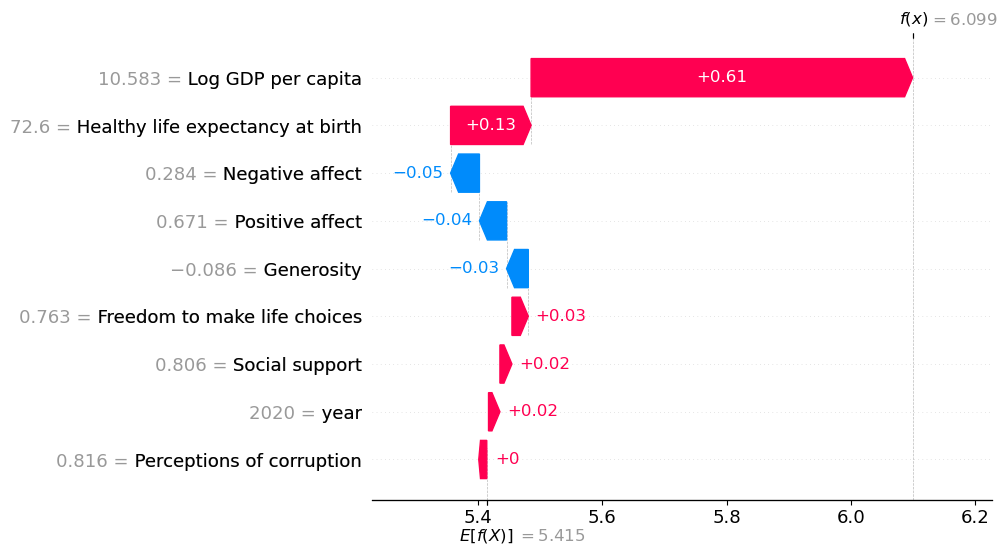

In [ ]:
#Summarize the SHAP values for a specific prediction (year 2020) with lightgbm model
shap.plots.waterfall(shap_values_lgbm[100])

### Waterfall LightGBM Regressor shows how each feature contributes to the prediction for one sample. In above sample prediction for sample 100, log gdp per capita has more positive contribution than Perception of corruption. This sample also shows that freedom to make life choices, social support and year has very least contribution towards prediction. Wheras the negative affect , Postive affect and Generosity features are pulling the prediction down.

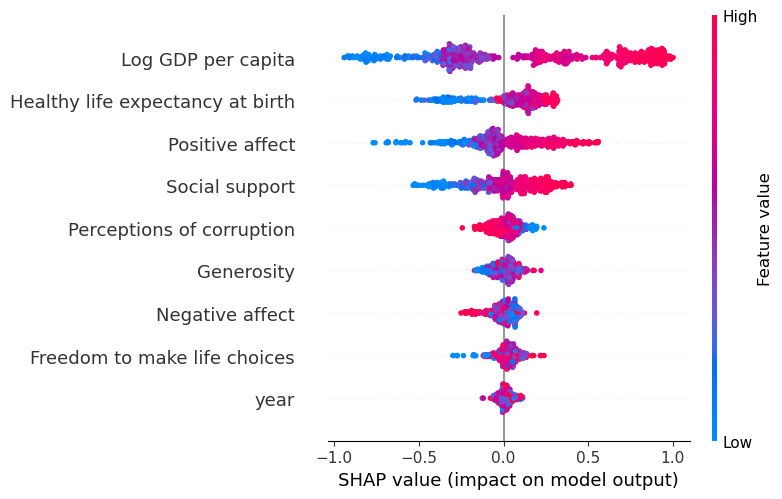

In [ ]:
shap.summary_plot(shap_values_lgbm[:500], features_test[:500], show= False)

### Summary plot on LightGBM Regressor gives global overview of feature importance distribution for all samples in whole dataset. This shows the whole dataset.  It can be seen that Log GDP per capita has more data points distribution which is in red. It can be concluded that this feature is moving the prediction to the higher followed by Positive affect and Social support.

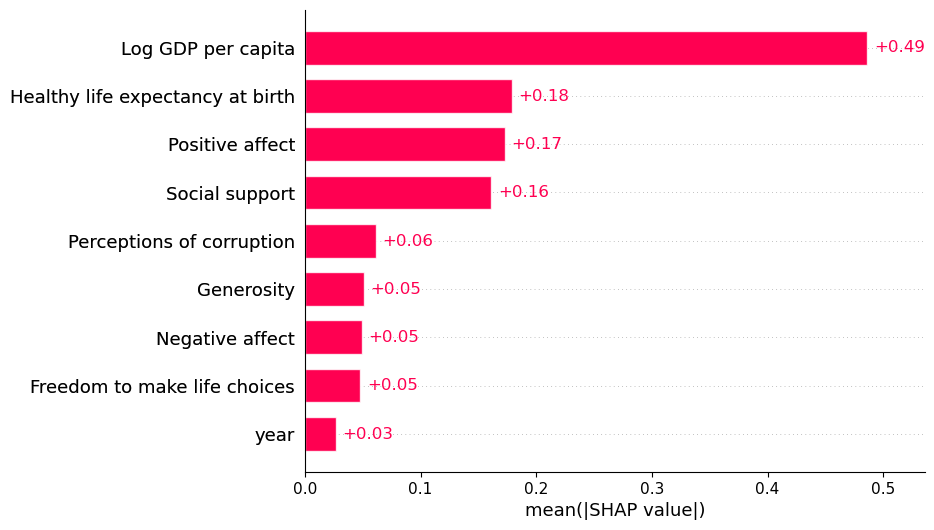

In [ ]:
shap.plots.bar(shap_values_lgbm)

### Bar plot on LightGBM Regressor is showing the average absolute SHAP values for each features. Its helps to understand which features are most important in the overall dataset. LightGBM model gave more importance to Log GDP per capita feature by (+0.13) than Catboost model . But on the other hand Light GBM gave less importance to Healthy life expectancy at birth than Catboost model.

In [ ]:

model2 = CatBoostRegressor(n_estimators= 190, max_depth= 8).fit(features_train, target_train)

explainer = shap.Explainer(model2, features_train)
shap_values_cbr = explainer(features_test, check_additivity=False)


Learning rate set to 0.172173
0:	learn: 0.9903169	total: 3.87ms	remaining: 732ms
1:	learn: 0.8790332	total: 6.95ms	remaining: 653ms
2:	learn: 0.7876228	total: 9.91ms	remaining: 618ms
3:	learn: 0.7154097	total: 12.8ms	remaining: 595ms
4:	learn: 0.6540750	total: 15.6ms	remaining: 578ms
5:	learn: 0.6068732	total: 18.4ms	remaining: 564ms
6:	learn: 0.5697233	total: 21.5ms	remaining: 563ms
7:	learn: 0.5352018	total: 24.2ms	remaining: 550ms
8:	learn: 0.5106410	total: 26.7ms	remaining: 536ms
9:	learn: 0.4911071	total: 29.4ms	remaining: 529ms
10:	learn: 0.4724149	total: 32.2ms	remaining: 525ms
11:	learn: 0.4561002	total: 35.4ms	remaining: 525ms
12:	learn: 0.4430904	total: 38.3ms	remaining: 521ms
13:	learn: 0.4333684	total: 41.2ms	remaining: 518ms
14:	learn: 0.4252867	total: 43.9ms	remaining: 512ms
15:	learn: 0.4165425	total: 46.9ms	remaining: 510ms
16:	learn: 0.4101592	total: 49.7ms	remaining: 506ms
17:	learn: 0.4037584	total: 53ms	remaining: 507ms
18:	learn: 0.3962134	total: 55.6ms	remaining: 

### Waterfall CatBoost Regressor shows how each feature contributes to the prediction for one sample. In above sample prediction for sample 100, log gdp per capita has more positive contribution followed by healthy life expectancy at birth.This sample also shows that freedom to make life choices, and Perception of corruption has very least contribution towards prediction. Whereas the Year, Social support, Negative affect , Postive affect and Generosity features are pulling the prediction down.

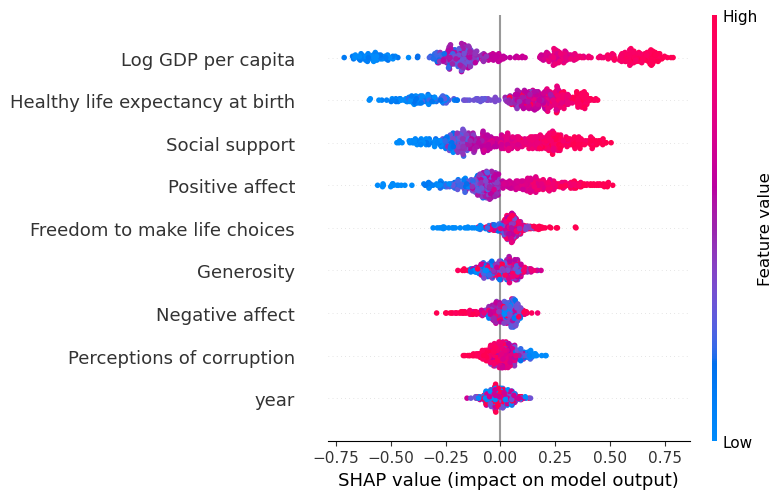

In [ ]:
shap.summary_plot(shap_values_cbr[:500], features_test[:500], show= False)

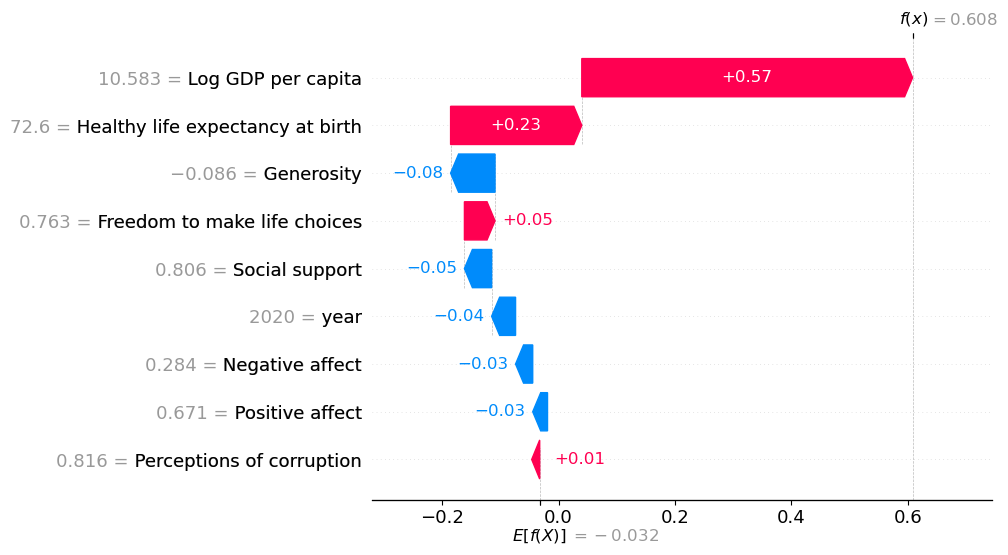

In [ ]:
#Summarize the SHAP values for a specific prediction (year 2020) with catboost model
shap.plots.waterfall(shap_values_cbr[100])

### Summary plot on CatBoost Regressor gives global overview of feature importance distribution for all samples in whole dataset. It can be seen that Log GDP per capita has more red data point which are moving towards the positive class(happiness). It can be concluded that this feature is moving the prediction to the higher which means it is increasing the model output followed by Positive affect, Social support, Healthy life expectancy at birth.

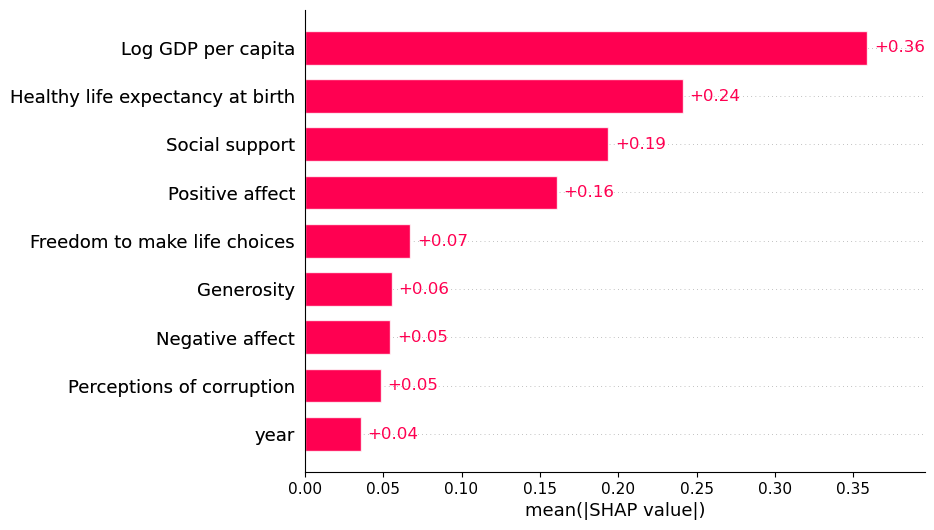

In [ ]:
shap.plots.bar(shap_values_cbr)

 ### Bar plot on CatBoost Regressor is showing the average absolute SHAP values for each features in whole dataset.  Its helps to understand which features are most important in the overall dataset. Catboost model gave little bit less importance than Light GBM model to Log GDP per capita feature. But on the other hand Catboost gave more importance to Healthy life expectancy at birth (+0.24) which is more than LightGBM by (+0.6).

## Conclusion on Shap 
 - The social support in the specific sample which was pulled is from year 2020. It was the time when COVID pandemic so that can be the reason why it is pulling prediction down in catboost model(0.05). As thier were less friends and family support as people were cooped up in thier own houses and unable to be in office setting or social setting due to quarantine rules.

 - Healthy life expectancy at birth was increasing happiness score even during covid as we see positive effect on prediction. So it can be said that this feature did not get much affected in 2020 due to COVID. It could be because both parents were home supporting each other mentally and physically.

 -  Higher Log GDP increase happiness: As needs and wants are both taken care.

 It is also noticed that freedom to life choices has minimal positive effect(+0.05) that year on happiness score because the rules got more strict than other years.



## 📘  Conclusions:
Based on our data visualizations, Finland and Iceland emerge as the top two happiest countries. Their high happiness scores are likely driven by factors such as high trust in government, strong work-life balance, and low levels of corruption. In contrast, Afghanistan ranks as the least happy country, primarily due to low social support, widespread poverty and unemployment, and weak governance.
Model building: Base model was created with linear regression. Catboost Regressor turned out to be best model with optuna hyper parameters as it gave lowest mean absolute error. Shap analysis was combined with best model to figure out feature importance. 
During covid year 2020 which was used for Shap prediction sample  for waterfall plot social support and generosity was pulling prediction towards negative class(less happy score). In the whole data set shap analysis showed Log GDP and Healthy life expectancy at birth pulling the model output towards high happiness score.

Our analysis also highlights that higher Log GDP per capita strongly correlates with increased happiness. This is because economic prosperity enables:
Fulfillment of basic needs,
Greater security and stability,
Access to opportunities and public services,
Improved social status through comparison.

Additionally, healthy life expectancy contributes significantly to happiness by enhancing quality of life, reducing stress, strengthening social bonds, and boosting national productivity.
Interestingly, generosity showed only a weak correlation (0.18) with happiness in this dataset, suggesting it may not be a primary driver of national well-being.

✅ Recommendations
Future studies could incorporate additional features such as climate, government spending, and cultural factors to better understand happiness.
Policymakers should focus more on less happy countries, identifying root causes and implementing targeted strategies to improve overall well-being.